Input dropout + Sparse

In [154]:
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from itertools import product
import pprint

from codes.utils import *
from codes.process import *
from codes.compare_auc_delong_fixed import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pp = pprint.PrettyPrinter(indent=4)

import warnings
warnings.filterwarnings('ignore') 
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.dpi"] = 300

random_seed=42
bed_root = '/home2/jpark/Projects/prs/data/bed'
y_value = 'y'  # Fix for all analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def shuffle_X_batch(X, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idx]
        yield X_batch

def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [39]:
# For fold
fold_num = 1
in_fold_num = 1

# For model
#learning_rate = 0.01
#sparsity_target = 0.2
#sparsity_weight = 0.3
dropout_rate = 0.3
#ex_num = 100

# For training
n_epochs = 200
batch_size = 16
#loss_test_min = 1000

In [43]:
def build_data(fold_num, in_fold_num, hparam, with_iid=False): 
    # Train data
    bed_X_train = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=hparam['en'])}.raw",
        delim_whitespace=True)
    bed_X_train = bed_X_train.iloc[:, [1] + list(range(6, len(bed_X_train.columns)))]
    bed_y_train = pd.read_csv(get_bed_path('label', 'train', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
    bed_data_train = bed_X_train.merge(bed_y_train, on='IID')

    # Test data
    bed_X_test = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=hparam['en'])}.raw",
        delim_whitespace=True)
    bed_X_test = bed_X_test.iloc[:, [1] + list(range(6, len(bed_X_test.columns)))]
    bed_y_test = pd.read_csv(get_bed_path('label', 'test', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
    bed_data_test = bed_X_test.merge(bed_y_test, on='IID')

    # Data set
    if with_iid:
        X_train = bed_data_train
        X_test = bed_data_test
    else:
        X_train = bed_data_train.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
        X_test = bed_data_test.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
    y_train = bed_data_train[y_value].to_numpy().astype(np.int32)
    y_test = bed_data_test[y_value].to_numpy().astype(np.int32)
    
    return X_train, y_train, X_test, y_test

def build_ssae(X_train, hparam):  #  Test 이후 문제 없으면 학습시에도 변경
    ##### Init #####
    reset_graph(random_seed)
    training = tf.placeholder_with_default(False, shape=(), name='training')
    n_inputs = X_train.shape[1]
    n_hidden = 10
    n_outputs = n_inputs

    ##### Build Model #####
    # input
    X_input = tf.placeholder(tf.float32, shape=[None, n_inputs])
    
    # layers
    X_drop = tf.layers.dropout(X_input, hparam['dr'], training=training)  # Input dropout
    hidden2 = tf.layers.dense(X_drop, n_hidden, activation=tf.nn.sigmoid)
    hidden1 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.sigmoid)
    hidden0 = tf.layers.dense(hidden1, 1, activation=tf.nn.sigmoid)
    hidden1r = tf.layers.dense(hidden0, n_hidden, activation=tf.nn.sigmoid)
    hidden2r = tf.layers.dense(hidden1r, n_hidden, activation=tf.nn.sigmoid)
    logits = tf.layers.dense(hidden2r, n_outputs)

    ##### Construct Loss #####
    # sparsity loss
    hidden_mean = tf.reduce_mean([hidden2, hidden1, hidden1r, hidden2r], axis=0)
    sparsity_loss = tf.reduce_sum(kl_divergence(hparam['st'], hidden_mean))

    # mean info  # Use mae as r_loss
    mae = tf.reduce_mean(tf.abs(logits - X_input))
#    mse = tf.reduce_mean(tf.square(logits-X_input))
#    c_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=X_input, logits=logits))  # cross  entropy 

    # Setting
    r_loss = mae

    # Reconstruction Loss
    loss = r_loss + hparam['sw'] * sparsity_loss

    # Optimizer
    optimizer = tf.train.AdamOptimizer(hparam['lr'])
    training_op = optimizer.minimize(loss)
    
    # Execute TF
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    return init, saver, mae, loss, hidden0

def process_network(X_train, y_train, X_test, y_test, fold_num, in_fold_num, hparam):
    result_list = []
    
    ##### Init #####
    reset_graph(random_seed)
    training = tf.placeholder_with_default(False, shape=(), name='training')
    n_inputs = X_train.shape[1]
    n_hidden = 10
    n_outputs = n_inputs

    ##### Build Model #####
    # input
    X_input = tf.placeholder(tf.float32, shape=[None, n_inputs])
    
    # layers
    X_drop = tf.layers.dropout(X_input, hparam['dr'], training=training)  # Input dropout
    hidden2 = tf.layers.dense(X_drop, n_hidden, activation=tf.nn.sigmoid)
    hidden1 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.sigmoid)
    hidden0 = tf.layers.dense(hidden1, 1, activation=tf.nn.sigmoid)
    hidden1r = tf.layers.dense(hidden0, n_hidden, activation=tf.nn.sigmoid)
    hidden2r = tf.layers.dense(hidden1r, n_hidden, activation=tf.nn.sigmoid)
    logits = tf.layers.dense(hidden2r, n_outputs)

    # output
    logits = tf.layers.dense(hidden2r, n_outputs)

    ##### Construct Loss #####
    # sparsity loss
    hidden_mean = tf.reduce_mean([hidden2, hidden1, hidden1r, hidden2r], axis=0)
    sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden_mean))

    # mean info  # Use mae as r_loss
    mae = tf.reduce_mean(tf.abs(logits - X_input))
#    mse = tf.reduce_mean(tf.square(logits-X_input))
#    c_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=X_input, logits=logits))  # cross  entropy 

    # Setting
    r_loss = mae

    # Reconstruction Loss
    loss = r_loss + hparam['sw'] * sparsity_loss

    # Optimizer
    optimizer = tf.train.AdamOptimizer(hparam['lr'])
    training_op = optimizer.minimize(loss)
    
    # Execute TF
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    mae_test_min = 1000
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs+1):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                #print(f'\r{100 * iteration // n_batches}%', end='')
                #sys.stdout.flush()
                X_batch = next(shuffle_X_batch(X_train, batch_size))
                sess.run(training_op, feed_dict={X_input: X_batch})
            if epoch % 10 == 0:
                mae_train, loss_train = sess.run([mae, loss], feed_dict={X_input: X_batch})
                mae_test, loss_test = sess.run([mae, loss], feed_dict={X_input: X_test})
                print(f'\r{epoch} Train, \tMAE: {mae_train: 4f}, \tLoss:, {loss_train:.4f}')
                print(f'\r{epoch} Test, \tMAE: {mae_test: 4f}, \tLoss:, {loss_test:.4f}')
                result_list.append([[epoch, fold_num, in_fold_num, hparam, mae_train, loss_train],
                                    [epoch, fold_num, in_fold_num, hparam, mae_test, loss_test]])
                if (mae_test_min > mae_test and epoch > 0) or epoch ==10:
                    mae_test_min = mae_test
                    saver.save(sess, get_bed_path('model_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value,
                                                  ex=hparam['en'], model_key=get_model_key(hparam), epoch=epoch))
                    print('Save model!')
                
    return result_list

def process_model(fold_num, in_fold_num, hparam):
    X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam)
    result_list = process_network(X_train, y_train, X_test, y_test, fold_num, in_fold_num, hparam)

    return result_list

In [1763]:
%%time
#lr_list = [0.01, 0.03]
#st_list = [0.5, 0.7]
#sw_list = [0.5, 0.7]
#dr_list = [0.3, 0.5]
lr_list = [0.01]
st_list = [0.5]
sw_list = [0.5]
dr_list = [0.5]
#en_list = [100]
#en_list = [1, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 5000, 7500, 10000, 20000, 30000, 50000]
en_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
# paer [0.01, 0.5, 0.5, 0.5, 100]

hdict = {}
# Find Hyper parameter
reset_graph()
for prod_num, prod_set in enumerate(product(*[lr_list, st_list, sw_list, dr_list, en_list])):
    hparam ={}
    hparam['lr'], hparam['st'], hparam['sw'], hparam['dr'], hparam['en'] = prod_set
    hcv_result = []    
    for fold_num in range(1,6):
#        for in_fold_num in ([None] + list(range(1,6))):
        for in_fold_num in ([None]):
            print(hparam, fold_num, in_fold_num)
            hcv_result.append(process_model(fold_num, in_fold_num, hparam))
    hdict[prod_num] = hcv_result  # prod_num -> [[[epoch train], [epoch test]]]

{'lr': 0.01, 'st': 0.5, 'sw': 0.5, 'dr': 0.5, 'en': 10} 1 None
0 Train, 	MAE:  0.001867, 	Loss:, 0.0047
0 Test, 	MAE:  0.017018, 	Loss:, 0.3005
10 Train, 	MAE:  0.019371, 	Loss:, 0.0194
10 Test, 	MAE:  0.016907, 	Loss:, 0.0176
Save model!
20 Train, 	MAE:  0.008067, 	Loss:, 0.0081
20 Test, 	MAE:  0.017312, 	Loss:, 0.0180
30 Train, 	MAE:  0.012843, 	Loss:, 0.0128
30 Test, 	MAE:  0.016277, 	Loss:, 0.0167
Save model!
40 Train, 	MAE:  0.001659, 	Loss:, 0.0017
40 Test, 	MAE:  0.016803, 	Loss:, 0.0348
50 Train, 	MAE:  0.001510, 	Loss:, 0.0015
50 Test, 	MAE:  0.016630, 	Loss:, 0.0185
60 Train, 	MAE:  0.006476, 	Loss:, 0.0065
60 Test, 	MAE:  0.015746, 	Loss:, 0.0158
Save model!
70 Train, 	MAE:  0.030427, 	Loss:, 0.0304
70 Test, 	MAE:  0.016192, 	Loss:, 0.0171
80 Train, 	MAE:  0.001222, 	Loss:, 0.0012
80 Test, 	MAE:  0.016360, 	Loss:, 0.0176
90 Train, 	MAE:  0.024275, 	Loss:, 0.0243
90 Test, 	MAE:  0.015929, 	Loss:, 0.0161
100 Train, 	MAE:  0.024516, 	Loss:, 0.0245
100 Test, 	MAE:  0.016162, 	Lo

0 Train, 	MAE:  0.020282, 	Loss:, 0.0269
0 Test, 	MAE:  0.034193, 	Loss:, 0.4688
10 Train, 	MAE:  0.014074, 	Loss:, 0.0141
10 Test, 	MAE:  0.033807, 	Loss:, 0.0340
Save model!
20 Train, 	MAE:  0.013193, 	Loss:, 0.0132
20 Test, 	MAE:  0.032984, 	Loss:, 0.0333
Save model!
30 Train, 	MAE:  0.030241, 	Loss:, 0.0302
30 Test, 	MAE:  0.032417, 	Loss:, 0.0325
Save model!
40 Train, 	MAE:  0.036209, 	Loss:, 0.0362
40 Test, 	MAE:  0.032509, 	Loss:, 0.0333
50 Train, 	MAE:  0.053927, 	Loss:, 0.0539
50 Test, 	MAE:  0.032588, 	Loss:, 0.0346
60 Train, 	MAE:  0.024482, 	Loss:, 0.0246
60 Test, 	MAE:  0.032539, 	Loss:, 0.0380
70 Train, 	MAE:  0.013322, 	Loss:, 0.0134
70 Test, 	MAE:  0.033120, 	Loss:, 0.0423
80 Train, 	MAE:  0.007306, 	Loss:, 0.0073
80 Test, 	MAE:  0.033027, 	Loss:, 0.0332
90 Train, 	MAE:  0.024734, 	Loss:, 0.0247
90 Test, 	MAE:  0.032810, 	Loss:, 0.0336
100 Train, 	MAE:  0.054107, 	Loss:, 0.0541
100 Test, 	MAE:  0.032793, 	Loss:, 0.0342
110 Train, 	MAE:  0.007783, 	Loss:, 0.0078
110 Test

170 Train, 	MAE:  0.046554, 	Loss:, 0.0466
170 Test, 	MAE:  0.046493, 	Loss:, 0.0690
180 Train, 	MAE:  0.042032, 	Loss:, 0.0421
180 Test, 	MAE:  0.040212, 	Loss:, 0.0621
190 Train, 	MAE:  0.026234, 	Loss:, 0.0263
190 Test, 	MAE:  0.046415, 	Loss:, 0.0680
200 Train, 	MAE:  0.044191, 	Loss:, 0.0450
200 Test, 	MAE:  0.041378, 	Loss:, 0.0637
{'lr': 0.01, 'st': 0.5, 'sw': 0.5, 'dr': 0.5, 'en': 10} 4 None
0 Train, 	MAE:  0.071678, 	Loss:, 0.0959
0 Test, 	MAE:  0.072758, 	Loss:, 1.2121
10 Train, 	MAE:  0.079565, 	Loss:, 0.0796
10 Test, 	MAE:  0.074814, 	Loss:, 0.0768
Save model!
20 Train, 	MAE:  0.095726, 	Loss:, 0.0958
20 Test, 	MAE:  0.073220, 	Loss:, 0.0749
Save model!
30 Train, 	MAE:  0.071768, 	Loss:, 0.0718
30 Test, 	MAE:  0.072331, 	Loss:, 0.0739
Save model!
40 Train, 	MAE:  0.083817, 	Loss:, 0.0838
40 Test, 	MAE:  0.072668, 	Loss:, 0.0735
50 Train, 	MAE:  0.065868, 	Loss:, 0.0659
50 Test, 	MAE:  0.072314, 	Loss:, 0.0726
Save model!
60 Train, 	MAE:  0.089499, 	Loss:, 0.0895
60 Test, 	M

0 Train, 	MAE:  0.025777, 	Loss:, 0.0350
0 Test, 	MAE:  0.039618, 	Loss:, 0.5463
10 Train, 	MAE:  0.014372, 	Loss:, 0.0144
10 Test, 	MAE:  0.039876, 	Loss:, 0.0403
Save model!
20 Train, 	MAE:  0.025702, 	Loss:, 0.0257
20 Test, 	MAE:  0.039580, 	Loss:, 0.0405
Save model!
30 Train, 	MAE:  0.066028, 	Loss:, 0.0660
30 Test, 	MAE:  0.038812, 	Loss:, 0.0390
Save model!
40 Train, 	MAE:  0.042226, 	Loss:, 0.0422
40 Test, 	MAE:  0.038451, 	Loss:, 0.0388
Save model!
50 Train, 	MAE:  0.036770, 	Loss:, 0.0368
50 Test, 	MAE:  0.038771, 	Loss:, 0.0389
60 Train, 	MAE:  0.025223, 	Loss:, 0.0252
60 Test, 	MAE:  0.039048, 	Loss:, 0.0393
70 Train, 	MAE:  0.036347, 	Loss:, 0.0364
70 Test, 	MAE:  0.038408, 	Loss:, 0.0445
Save model!
80 Train, 	MAE:  0.048004, 	Loss:, 0.0481
80 Test, 	MAE:  0.038328, 	Loss:, 0.0426
Save model!
90 Train, 	MAE:  0.083223, 	Loss:, 0.0834
90 Test, 	MAE:  0.038281, 	Loss:, 0.0411
Save model!
100 Train, 	MAE:  0.042095, 	Loss:, 0.0421
100 Test, 	MAE:  0.038275, 	Loss:, 0.0389
Sav

40 Train, 	MAE:  0.110378, 	Loss:, 0.1104
40 Test, 	MAE:  0.082018, 	Loss:, 0.0848
Save model!
50 Train, 	MAE:  0.055041, 	Loss:, 0.0554
50 Test, 	MAE:  0.082049, 	Loss:, 0.0870
60 Train, 	MAE:  0.080164, 	Loss:, 0.0802
60 Test, 	MAE:  0.081469, 	Loss:, 0.0831
Save model!
70 Train, 	MAE:  0.099388, 	Loss:, 0.0995
70 Test, 	MAE:  0.081733, 	Loss:, 0.0865
80 Train, 	MAE:  0.057723, 	Loss:, 0.0578
80 Test, 	MAE:  0.082312, 	Loss:, 0.0855
90 Train, 	MAE:  0.042880, 	Loss:, 0.0429
90 Test, 	MAE:  0.081733, 	Loss:, 0.0845
100 Train, 	MAE:  0.094563, 	Loss:, 0.0946
100 Test, 	MAE:  0.081631, 	Loss:, 0.0851
110 Train, 	MAE:  0.048499, 	Loss:, 0.0485
110 Test, 	MAE:  0.081453, 	Loss:, 0.0838
Save model!
120 Train, 	MAE:  0.060285, 	Loss:, 0.0603
120 Test, 	MAE:  0.081538, 	Loss:, 0.0835
130 Train, 	MAE:  0.085021, 	Loss:, 0.0850
130 Test, 	MAE:  0.081579, 	Loss:, 0.0835
140 Train, 	MAE:  0.052436, 	Loss:, 0.0524
140 Test, 	MAE:  0.081901, 	Loss:, 0.0837
150 Train, 	MAE:  0.085473, 	Loss:, 0.085

0 Train, 	MAE:  0.450228, 	Loss:, 0.5181
0 Test, 	MAE:  0.500896, 	Loss:, 0.6894
10 Train, 	MAE:  0.444188, 	Loss:, 0.4443
10 Test, 	MAE:  0.498466, 	Loss:, 0.5253
Save model!
20 Train, 	MAE:  0.069113, 	Loss:, 0.0729
20 Test, 	MAE:  0.112519, 	Loss:, 0.2568
Save model!
30 Train, 	MAE:  0.054382, 	Loss:, 0.0560
30 Test, 	MAE:  0.096219, 	Loss:, 0.1644
Save model!
40 Train, 	MAE:  0.104330, 	Loss:, 0.1051
40 Test, 	MAE:  0.138370, 	Loss:, 0.1902
50 Train, 	MAE:  0.127648, 	Loss:, 0.1282
50 Test, 	MAE:  0.097434, 	Loss:, 0.1361
60 Train, 	MAE:  0.159139, 	Loss:, 0.1600
60 Test, 	MAE:  0.125007, 	Loss:, 0.1656
70 Train, 	MAE:  0.058001, 	Loss:, 0.0586
70 Test, 	MAE:  0.085936, 	Loss:, 0.1215
Save model!
80 Train, 	MAE:  0.050018, 	Loss:, 0.0502
80 Test, 	MAE:  0.078223, 	Loss:, 0.1015
Save model!
90 Train, 	MAE:  0.050946, 	Loss:, 0.0533
90 Test, 	MAE:  0.077264, 	Loss:, 0.1042
Save model!
100 Train, 	MAE:  0.115835, 	Loss:, 0.1162
100 Test, 	MAE:  0.124012, 	Loss:, 0.1708
110 Train, 	MAE

0 Train, 	MAE:  0.041752, 	Loss:, 0.0601
0 Test, 	MAE:  0.043796, 	Loss:, 1.1047
10 Train, 	MAE:  0.043398, 	Loss:, 0.0438
10 Test, 	MAE:  0.044260, 	Loss:, 0.0661
Save model!
20 Train, 	MAE:  0.048663, 	Loss:, 0.0488
20 Test, 	MAE:  0.043763, 	Loss:, 0.0485
Save model!
30 Train, 	MAE:  0.048058, 	Loss:, 0.0482
30 Test, 	MAE:  0.043007, 	Loss:, 0.0484
Save model!
40 Train, 	MAE:  0.029963, 	Loss:, 0.0300
40 Test, 	MAE:  0.033070, 	Loss:, 0.0362
Save model!
50 Train, 	MAE:  0.014673, 	Loss:, 0.0147
50 Test, 	MAE:  0.033127, 	Loss:, 0.0355
60 Train, 	MAE:  0.040159, 	Loss:, 0.0402
60 Test, 	MAE:  0.032717, 	Loss:, 0.0338
Save model!
70 Train, 	MAE:  0.036728, 	Loss:, 0.0370
70 Test, 	MAE:  0.032741, 	Loss:, 0.0403
80 Train, 	MAE:  0.033177, 	Loss:, 0.0332
80 Test, 	MAE:  0.032649, 	Loss:, 0.0347
Save model!
90 Train, 	MAE:  0.021433, 	Loss:, 0.0215
90 Test, 	MAE:  0.032821, 	Loss:, 0.0346
100 Train, 	MAE:  0.037732, 	Loss:, 0.0378
100 Test, 	MAE:  0.032691, 	Loss:, 0.0340
110 Train, 	MAE

0 Train, 	MAE:  0.184485, 	Loss:, 0.1924
0 Test, 	MAE:  0.176694, 	Loss:, 1.3012
10 Train, 	MAE:  0.078711, 	Loss:, 0.0852
10 Test, 	MAE:  0.071626, 	Loss:, 0.4377
Save model!
20 Train, 	MAE:  0.054496, 	Loss:, 0.0550
20 Test, 	MAE:  0.052332, 	Loss:, 0.0901
Save model!
30 Train, 	MAE:  0.046643, 	Loss:, 0.0469
30 Test, 	MAE:  0.053139, 	Loss:, 0.0745
40 Train, 	MAE:  0.073629, 	Loss:, 0.0739
40 Test, 	MAE:  0.059369, 	Loss:, 0.0759
50 Train, 	MAE:  0.037534, 	Loss:, 0.0452
50 Test, 	MAE:  0.050795, 	Loss:, 0.1180
Save model!
60 Train, 	MAE:  0.055379, 	Loss:, 0.0555
60 Test, 	MAE:  0.057886, 	Loss:, 0.0693
70 Train, 	MAE:  0.065549, 	Loss:, 0.0656
70 Test, 	MAE:  0.052456, 	Loss:, 0.1622
80 Train, 	MAE:  0.040589, 	Loss:, 0.0406
80 Test, 	MAE:  0.057449, 	Loss:, 0.0676
90 Train, 	MAE:  0.040045, 	Loss:, 0.0407
90 Test, 	MAE:  0.054893, 	Loss:, 0.0826
100 Train, 	MAE:  0.056195, 	Loss:, 0.0563
100 Test, 	MAE:  0.051157, 	Loss:, 0.0863
110 Train, 	MAE:  0.033355, 	Loss:, 0.0334
110 Test

0 Train, 	MAE:  0.181166, 	Loss:, 0.1815
0 Test, 	MAE:  0.193036, 	Loss:, 0.3642
10 Train, 	MAE:  0.226131, 	Loss:, 0.2262
10 Test, 	MAE:  0.192799, 	Loss:, 0.2304
Save model!
20 Train, 	MAE:  0.181198, 	Loss:, 0.1812
20 Test, 	MAE:  0.192091, 	Loss:, 0.2029
Save model!
30 Train, 	MAE:  0.202075, 	Loss:, 0.2021
30 Test, 	MAE:  0.191990, 	Loss:, 0.1969
Save model!
40 Train, 	MAE:  0.196586, 	Loss:, 0.1966
40 Test, 	MAE:  0.191679, 	Loss:, 0.1959
Save model!
50 Train, 	MAE:  0.228207, 	Loss:, 0.2282
50 Test, 	MAE:  0.191682, 	Loss:, 0.1929
60 Train, 	MAE:  0.216934, 	Loss:, 0.2170
60 Test, 	MAE:  0.191547, 	Loss:, 0.1927
Save model!
70 Train, 	MAE:  0.211040, 	Loss:, 0.2110
70 Test, 	MAE:  0.191451, 	Loss:, 0.1922
Save model!
80 Train, 	MAE:  0.097279, 	Loss:, 0.0983
80 Test, 	MAE:  0.091414, 	Loss:, 0.1304
Save model!
90 Train, 	MAE:  0.077681, 	Loss:, 0.0778
90 Test, 	MAE:  0.079199, 	Loss:, 0.0864
Save model!
100 Train, 	MAE:  0.066072, 	Loss:, 0.0662
100 Test, 	MAE:  0.078801, 	Loss:

0 Train, 	MAE:  0.085525, 	Loss:, 0.0963
0 Test, 	MAE:  0.092851, 	Loss:, 0.7892
10 Train, 	MAE:  0.095209, 	Loss:, 0.0957
10 Test, 	MAE:  0.092547, 	Loss:, 0.1592
Save model!
20 Train, 	MAE:  0.050818, 	Loss:, 0.0512
20 Test, 	MAE:  0.055576, 	Loss:, 0.0913
Save model!
30 Train, 	MAE:  0.054147, 	Loss:, 0.0543
30 Test, 	MAE:  0.055432, 	Loss:, 0.0721
Save model!
40 Train, 	MAE:  0.045742, 	Loss:, 0.0460
40 Test, 	MAE:  0.054916, 	Loss:, 0.0713
Save model!
50 Train, 	MAE:  0.040166, 	Loss:, 0.0403
50 Test, 	MAE:  0.055650, 	Loss:, 0.0676
60 Train, 	MAE:  0.050456, 	Loss:, 0.0505
60 Test, 	MAE:  0.055138, 	Loss:, 0.0628
70 Train, 	MAE:  0.040393, 	Loss:, 0.0404
70 Test, 	MAE:  0.054964, 	Loss:, 0.0595
80 Train, 	MAE:  0.055328, 	Loss:, 0.0554
80 Test, 	MAE:  0.054658, 	Loss:, 0.0583
Save model!
90 Train, 	MAE:  0.042490, 	Loss:, 0.0425
90 Test, 	MAE:  0.055541, 	Loss:, 0.0609
100 Train, 	MAE:  0.046034, 	Loss:, 0.0462
100 Test, 	MAE:  0.055232, 	Loss:, 0.0607
110 Train, 	MAE:  0.038824,

0 Train, 	MAE:  0.136420, 	Loss:, 0.1836
0 Test, 	MAE:  0.209460, 	Loss:, 1.4877
10 Train, 	MAE:  0.089673, 	Loss:, 0.1020
10 Test, 	MAE:  0.096649, 	Loss:, 0.7903
Save model!
20 Train, 	MAE:  0.076661, 	Loss:, 0.0773
20 Test, 	MAE:  0.064329, 	Loss:, 0.1174
Save model!
30 Train, 	MAE:  0.057235, 	Loss:, 0.0581
30 Test, 	MAE:  0.063955, 	Loss:, 0.0822
Save model!
40 Train, 	MAE:  0.054289, 	Loss:, 0.0544
40 Test, 	MAE:  0.068871, 	Loss:, 0.1145
50 Train, 	MAE:  0.047155, 	Loss:, 0.0473
50 Test, 	MAE:  0.061087, 	Loss:, 0.0885
Save model!
60 Train, 	MAE:  0.045754, 	Loss:, 0.0458
60 Test, 	MAE:  0.065068, 	Loss:, 0.1092
70 Train, 	MAE:  0.082773, 	Loss:, 0.0829
70 Test, 	MAE:  0.063360, 	Loss:, 0.0728
80 Train, 	MAE:  0.043160, 	Loss:, 0.0432
80 Test, 	MAE:  0.061479, 	Loss:, 0.0677
90 Train, 	MAE:  0.076195, 	Loss:, 0.0767
90 Test, 	MAE:  0.061525, 	Loss:, 0.0697
100 Train, 	MAE:  0.054637, 	Loss:, 0.0554
100 Test, 	MAE:  0.069934, 	Loss:, 0.1123
110 Train, 	MAE:  0.062975, 	Loss:, 0.0

0 Train, 	MAE:  0.221894, 	Loss:, 0.2219
0 Test, 	MAE:  0.220072, 	Loss:, 0.2285
10 Train, 	MAE:  0.258936, 	Loss:, 0.2589
10 Test, 	MAE:  0.219014, 	Loss:, 0.2233
Save model!
20 Train, 	MAE:  0.195670, 	Loss:, 0.1957
20 Test, 	MAE:  0.218581, 	Loss:, 0.2209
Save model!
30 Train, 	MAE:  0.218479, 	Loss:, 0.2185
30 Test, 	MAE:  0.218309, 	Loss:, 0.2198
Save model!
40 Train, 	MAE:  0.229384, 	Loss:, 0.2294
40 Test, 	MAE:  0.218191, 	Loss:, 0.2193
Save model!
50 Train, 	MAE:  0.229677, 	Loss:, 0.2297
50 Test, 	MAE:  0.217886, 	Loss:, 0.2185
Save model!
60 Train, 	MAE:  0.246146, 	Loss:, 0.2461
60 Test, 	MAE:  0.217858, 	Loss:, 0.2181
Save model!
70 Train, 	MAE:  0.215787, 	Loss:, 0.2158
70 Test, 	MAE:  0.217875, 	Loss:, 0.2181
80 Train, 	MAE:  0.234340, 	Loss:, 0.2343
80 Test, 	MAE:  0.217864, 	Loss:, 0.2180
90 Train, 	MAE:  0.232949, 	Loss:, 0.2330
90 Test, 	MAE:  0.218020, 	Loss:, 0.2181
100 Train, 	MAE:  0.228585, 	Loss:, 0.2286
100 Test, 	MAE:  0.217806, 	Loss:, 0.2179
Save model!
110

0 Train, 	MAE:  0.195742, 	Loss:, 0.1958
0 Test, 	MAE:  0.207171, 	Loss:, 0.2078
10 Train, 	MAE:  0.192698, 	Loss:, 0.1927
10 Test, 	MAE:  0.206463, 	Loss:, 0.2070
Save model!
20 Train, 	MAE:  0.190013, 	Loss:, 0.1900
20 Test, 	MAE:  0.206051, 	Loss:, 0.2065
Save model!
30 Train, 	MAE:  0.214970, 	Loss:, 0.2150
30 Test, 	MAE:  0.205731, 	Loss:, 0.2060
Save model!
40 Train, 	MAE:  0.220167, 	Loss:, 0.2202
40 Test, 	MAE:  0.205565, 	Loss:, 0.2058
Save model!
50 Train, 	MAE:  0.150738, 	Loss:, 0.1507
50 Test, 	MAE:  0.205414, 	Loss:, 0.2056
Save model!
60 Train, 	MAE:  0.231845, 	Loss:, 0.2318
60 Test, 	MAE:  0.205485, 	Loss:, 0.2057
70 Train, 	MAE:  0.187204, 	Loss:, 0.1872
70 Test, 	MAE:  0.205381, 	Loss:, 0.2055
Save model!
80 Train, 	MAE:  0.182155, 	Loss:, 0.1822
80 Test, 	MAE:  0.205367, 	Loss:, 0.2054
Save model!
90 Train, 	MAE:  0.169434, 	Loss:, 0.1694
90 Test, 	MAE:  0.205348, 	Loss:, 0.2054
Save model!
100 Train, 	MAE:  0.154135, 	Loss:, 0.1541
100 Test, 	MAE:  0.205353, 	Loss:

0 Train, 	MAE:  0.149645, 	Loss:, 0.1496
0 Test, 	MAE:  0.162500, 	Loss:, 0.1635
10 Train, 	MAE:  0.170194, 	Loss:, 0.1702
10 Test, 	MAE:  0.162281, 	Loss:, 0.1632
Save model!
20 Train, 	MAE:  0.158830, 	Loss:, 0.1588
20 Test, 	MAE:  0.161831, 	Loss:, 0.1628
Save model!
30 Train, 	MAE:  0.178421, 	Loss:, 0.1784
30 Test, 	MAE:  0.161502, 	Loss:, 0.1623
Save model!
40 Train, 	MAE:  0.182368, 	Loss:, 0.1824
40 Test, 	MAE:  0.161374, 	Loss:, 0.1619
Save model!
50 Train, 	MAE:  0.132706, 	Loss:, 0.1327
50 Test, 	MAE:  0.161092, 	Loss:, 0.1614
Save model!
60 Train, 	MAE:  0.144905, 	Loss:, 0.1449
60 Test, 	MAE:  0.161142, 	Loss:, 0.1614
70 Train, 	MAE:  0.133848, 	Loss:, 0.1338
70 Test, 	MAE:  0.161188, 	Loss:, 0.1614
80 Train, 	MAE:  0.149060, 	Loss:, 0.1491
80 Test, 	MAE:  0.161247, 	Loss:, 0.1614
90 Train, 	MAE:  0.123142, 	Loss:, 0.1231
90 Test, 	MAE:  0.161210, 	Loss:, 0.1613
100 Train, 	MAE:  0.163224, 	Loss:, 0.1632
100 Test, 	MAE:  0.161166, 	Loss:, 0.1613
110 Train, 	MAE:  0.156755,

0 Train, 	MAE:  0.174304, 	Loss:, 0.1743
0 Test, 	MAE:  0.163400, 	Loss:, 0.1635
10 Train, 	MAE:  0.158124, 	Loss:, 0.1581
10 Test, 	MAE:  0.162918, 	Loss:, 0.1630
Save model!
20 Train, 	MAE:  0.165738, 	Loss:, 0.1657
20 Test, 	MAE:  0.162395, 	Loss:, 0.1625
Save model!
30 Train, 	MAE:  0.168994, 	Loss:, 0.1690
30 Test, 	MAE:  0.162099, 	Loss:, 0.1622
Save model!
40 Train, 	MAE:  0.145617, 	Loss:, 0.1456
40 Test, 	MAE:  0.161920, 	Loss:, 0.1620
Save model!
50 Train, 	MAE:  0.161436, 	Loss:, 0.1614
50 Test, 	MAE:  0.161792, 	Loss:, 0.1619
Save model!
60 Train, 	MAE:  0.158044, 	Loss:, 0.1580
60 Test, 	MAE:  0.161788, 	Loss:, 0.1619
Save model!
70 Train, 	MAE:  0.169907, 	Loss:, 0.1699
70 Test, 	MAE:  0.161767, 	Loss:, 0.1619
Save model!
80 Train, 	MAE:  0.156732, 	Loss:, 0.1567
80 Test, 	MAE:  0.161757, 	Loss:, 0.1618
Save model!
90 Train, 	MAE:  0.149295, 	Loss:, 0.1493
90 Test, 	MAE:  0.161742, 	Loss:, 0.1618
Save model!
100 Train, 	MAE:  0.154574, 	Loss:, 0.1546
100 Test, 	MAE:  0.16

0 Train, 	MAE:  0.176445, 	Loss:, 0.1764
0 Test, 	MAE:  0.179319, 	Loss:, 0.1794
10 Train, 	MAE:  0.173277, 	Loss:, 0.1733
10 Test, 	MAE:  0.178796, 	Loss:, 0.1788
Save model!
20 Train, 	MAE:  0.169319, 	Loss:, 0.1693
20 Test, 	MAE:  0.178285, 	Loss:, 0.1784
Save model!
30 Train, 	MAE:  0.183392, 	Loss:, 0.1834
30 Test, 	MAE:  0.177975, 	Loss:, 0.1781
Save model!
40 Train, 	MAE:  0.189620, 	Loss:, 0.1896
40 Test, 	MAE:  0.177802, 	Loss:, 0.1779
Save model!
50 Train, 	MAE:  0.145319, 	Loss:, 0.1453
50 Test, 	MAE:  0.177743, 	Loss:, 0.1778
Save model!
60 Train, 	MAE:  0.196119, 	Loss:, 0.1961
60 Test, 	MAE:  0.177694, 	Loss:, 0.1778
Save model!
70 Train, 	MAE:  0.173484, 	Loss:, 0.1735
70 Test, 	MAE:  0.177695, 	Loss:, 0.1778
80 Train, 	MAE:  0.161679, 	Loss:, 0.1617
80 Test, 	MAE:  0.177734, 	Loss:, 0.1779
90 Train, 	MAE:  0.159922, 	Loss:, 0.1599
90 Test, 	MAE:  0.177705, 	Loss:, 0.1778
100 Train, 	MAE:  0.153590, 	Loss:, 0.1536
100 Test, 	MAE:  0.177660, 	Loss:, 0.1777
Save model!
110

0 Train, 	MAE:  0.151416, 	Loss:, 0.1514
0 Test, 	MAE:  0.152134, 	Loss:, 0.1522
10 Train, 	MAE:  0.146252, 	Loss:, 0.1463
10 Test, 	MAE:  0.151745, 	Loss:, 0.1518
Save model!
20 Train, 	MAE:  0.144141, 	Loss:, 0.1441
20 Test, 	MAE:  0.151195, 	Loss:, 0.1513
Save model!
30 Train, 	MAE:  0.152575, 	Loss:, 0.1526
30 Test, 	MAE:  0.150882, 	Loss:, 0.1509
Save model!
40 Train, 	MAE:  0.156139, 	Loss:, 0.1561
40 Test, 	MAE:  0.150831, 	Loss:, 0.1510
Save model!
50 Train, 	MAE:  0.133629, 	Loss:, 0.1336
50 Test, 	MAE:  0.150671, 	Loss:, 0.1508
Save model!
60 Train, 	MAE:  0.140395, 	Loss:, 0.1404
60 Test, 	MAE:  0.150577, 	Loss:, 0.1506
Save model!
70 Train, 	MAE:  0.146385, 	Loss:, 0.1464
70 Test, 	MAE:  0.150589, 	Loss:, 0.1507
80 Train, 	MAE:  0.153005, 	Loss:, 0.1530
80 Test, 	MAE:  0.150659, 	Loss:, 0.1508
90 Train, 	MAE:  0.144224, 	Loss:, 0.1442
90 Test, 	MAE:  0.150676, 	Loss:, 0.1508
100 Train, 	MAE:  0.166535, 	Loss:, 0.1665
100 Test, 	MAE:  0.150670, 	Loss:, 0.1507
110 Train, 	MAE

0 Train, 	MAE:  0.204997, 	Loss:, 0.2050
0 Test, 	MAE:  0.202058, 	Loss:, 0.2021
10 Train, 	MAE:  0.206681, 	Loss:, 0.2067
10 Test, 	MAE:  0.201631, 	Loss:, 0.2017
Save model!
20 Train, 	MAE:  0.204235, 	Loss:, 0.2042
20 Test, 	MAE:  0.201053, 	Loss:, 0.2012
Save model!
30 Train, 	MAE:  0.202345, 	Loss:, 0.2023
30 Test, 	MAE:  0.200788, 	Loss:, 0.2009
Save model!
40 Train, 	MAE:  0.194109, 	Loss:, 0.1941
40 Test, 	MAE:  0.200659, 	Loss:, 0.2008
Save model!
50 Train, 	MAE:  0.195416, 	Loss:, 0.1954
50 Test, 	MAE:  0.200592, 	Loss:, 0.2007
Save model!
60 Train, 	MAE:  0.198240, 	Loss:, 0.1982
60 Test, 	MAE:  0.200548, 	Loss:, 0.2006
Save model!
70 Train, 	MAE:  0.205890, 	Loss:, 0.2059
70 Test, 	MAE:  0.200562, 	Loss:, 0.2006
80 Train, 	MAE:  0.200130, 	Loss:, 0.2001
80 Test, 	MAE:  0.200486, 	Loss:, 0.2006
Save model!
90 Train, 	MAE:  0.190700, 	Loss:, 0.1907
90 Test, 	MAE:  0.200547, 	Loss:, 0.2007
100 Train, 	MAE:  0.199814, 	Loss:, 0.1998
100 Test, 	MAE:  0.200506, 	Loss:, 0.2006
110

0 Train, 	MAE:  0.193453, 	Loss:, 0.1935
0 Test, 	MAE:  0.194217, 	Loss:, 0.1944
10 Train, 	MAE:  0.204228, 	Loss:, 0.2042
10 Test, 	MAE:  0.193866, 	Loss:, 0.1940
Save model!
20 Train, 	MAE:  0.191302, 	Loss:, 0.1913
20 Test, 	MAE:  0.193218, 	Loss:, 0.1933
Save model!
30 Train, 	MAE:  0.197651, 	Loss:, 0.1977
30 Test, 	MAE:  0.192916, 	Loss:, 0.1930
Save model!
40 Train, 	MAE:  0.198644, 	Loss:, 0.1986
40 Test, 	MAE:  0.192756, 	Loss:, 0.1929
Save model!
50 Train, 	MAE:  0.183697, 	Loss:, 0.1837
50 Test, 	MAE:  0.192737, 	Loss:, 0.1928
Save model!
60 Train, 	MAE:  0.187587, 	Loss:, 0.1876
60 Test, 	MAE:  0.192723, 	Loss:, 0.1928
Save model!
70 Train, 	MAE:  0.196874, 	Loss:, 0.1969
70 Test, 	MAE:  0.192717, 	Loss:, 0.1928
Save model!
80 Train, 	MAE:  0.195321, 	Loss:, 0.1953
80 Test, 	MAE:  0.192701, 	Loss:, 0.1928
Save model!
90 Train, 	MAE:  0.193187, 	Loss:, 0.1932
90 Test, 	MAE:  0.192806, 	Loss:, 0.1929
100 Train, 	MAE:  0.186580, 	Loss:, 0.1866
100 Test, 	MAE:  0.192731, 	Loss:

0 Train, 	MAE:  0.205639, 	Loss:, 0.2056
0 Test, 	MAE:  0.193731, 	Loss:, 0.1938
10 Train, 	MAE:  0.183703, 	Loss:, 0.1837
10 Test, 	MAE:  0.193301, 	Loss:, 0.1934
Save model!
20 Train, 	MAE:  0.184675, 	Loss:, 0.1847
20 Test, 	MAE:  0.192724, 	Loss:, 0.1928
Save model!
30 Train, 	MAE:  0.199595, 	Loss:, 0.1996
30 Test, 	MAE:  0.192376, 	Loss:, 0.1924
Save model!
40 Train, 	MAE:  0.184116, 	Loss:, 0.1841
40 Test, 	MAE:  0.192232, 	Loss:, 0.1923
Save model!
50 Train, 	MAE:  0.178645, 	Loss:, 0.1786
50 Test, 	MAE:  0.192148, 	Loss:, 0.1921
Save model!
60 Train, 	MAE:  0.194088, 	Loss:, 0.1941
60 Test, 	MAE:  0.192156, 	Loss:, 0.1923
70 Train, 	MAE:  0.181440, 	Loss:, 0.1814
70 Test, 	MAE:  0.192159, 	Loss:, 0.1922
80 Train, 	MAE:  0.177688, 	Loss:, 0.1777
80 Test, 	MAE:  0.192196, 	Loss:, 0.1923
90 Train, 	MAE:  0.205630, 	Loss:, 0.2056
90 Test, 	MAE:  0.192201, 	Loss:, 0.1923
100 Train, 	MAE:  0.190978, 	Loss:, 0.1910
100 Test, 	MAE:  0.192163, 	Loss:, 0.1923
110 Train, 	MAE:  0.194819,

0 Train, 	MAE:  0.218860, 	Loss:, 0.2189
0 Test, 	MAE:  0.203724, 	Loss:, 0.2038
10 Train, 	MAE:  0.223398, 	Loss:, 0.2234
10 Test, 	MAE:  0.203365, 	Loss:, 0.2034
Save model!
20 Train, 	MAE:  0.179979, 	Loss:, 0.1800
20 Test, 	MAE:  0.202743, 	Loss:, 0.2028
Save model!
30 Train, 	MAE:  0.215999, 	Loss:, 0.2160
30 Test, 	MAE:  0.202458, 	Loss:, 0.2026
Save model!
40 Train, 	MAE:  0.212383, 	Loss:, 0.2124
40 Test, 	MAE:  0.202294, 	Loss:, 0.2023
Save model!
50 Train, 	MAE:  0.205194, 	Loss:, 0.2052
50 Test, 	MAE:  0.202235, 	Loss:, 0.2022
Save model!
60 Train, 	MAE:  0.215684, 	Loss:, 0.2157
60 Test, 	MAE:  0.202206, 	Loss:, 0.2023
Save model!
70 Train, 	MAE:  0.192804, 	Loss:, 0.1928
70 Test, 	MAE:  0.202207, 	Loss:, 0.2023
80 Train, 	MAE:  0.198316, 	Loss:, 0.1983
80 Test, 	MAE:  0.202206, 	Loss:, 0.2022
Save model!
90 Train, 	MAE:  0.197298, 	Loss:, 0.1973
90 Test, 	MAE:  0.202235, 	Loss:, 0.2023
100 Train, 	MAE:  0.179694, 	Loss:, 0.1797
100 Test, 	MAE:  0.202199, 	Loss:, 0.2022
Sav

0 Train, 	MAE:  0.207176, 	Loss:, 0.2072
0 Test, 	MAE:  0.207532, 	Loss:, 0.2076
10 Train, 	MAE:  0.217177, 	Loss:, 0.2172
10 Test, 	MAE:  0.207192, 	Loss:, 0.2073
Save model!
20 Train, 	MAE:  0.205823, 	Loss:, 0.2058
20 Test, 	MAE:  0.206638, 	Loss:, 0.2067
Save model!
30 Train, 	MAE:  0.213485, 	Loss:, 0.2135
30 Test, 	MAE:  0.206341, 	Loss:, 0.2064
Save model!
40 Train, 	MAE:  0.208312, 	Loss:, 0.2083
40 Test, 	MAE:  0.206136, 	Loss:, 0.2062
Save model!
50 Train, 	MAE:  0.196200, 	Loss:, 0.1962
50 Test, 	MAE:  0.206131, 	Loss:, 0.2062
Save model!
60 Train, 	MAE:  0.202116, 	Loss:, 0.2021
60 Test, 	MAE:  0.206126, 	Loss:, 0.2062
Save model!
70 Train, 	MAE:  0.208536, 	Loss:, 0.2085
70 Test, 	MAE:  0.206103, 	Loss:, 0.2062
Save model!
80 Train, 	MAE:  0.206999, 	Loss:, 0.2070
80 Test, 	MAE:  0.206075, 	Loss:, 0.2062
Save model!
90 Train, 	MAE:  0.207005, 	Loss:, 0.2070
90 Test, 	MAE:  0.206128, 	Loss:, 0.2063
100 Train, 	MAE:  0.201262, 	Loss:, 0.2013
100 Test, 	MAE:  0.206098, 	Loss:

0 Train, 	MAE:  0.196519, 	Loss:, 0.1965
0 Test, 	MAE:  0.196615, 	Loss:, 0.1967
10 Train, 	MAE:  0.206265, 	Loss:, 0.2063
10 Test, 	MAE:  0.196216, 	Loss:, 0.1963
Save model!
20 Train, 	MAE:  0.195570, 	Loss:, 0.1956
20 Test, 	MAE:  0.195646, 	Loss:, 0.1957
Save model!
30 Train, 	MAE:  0.192233, 	Loss:, 0.1922
30 Test, 	MAE:  0.195354, 	Loss:, 0.1954
Save model!
40 Train, 	MAE:  0.197860, 	Loss:, 0.1979
40 Test, 	MAE:  0.195235, 	Loss:, 0.1953
Save model!
50 Train, 	MAE:  0.189927, 	Loss:, 0.1899
50 Test, 	MAE:  0.195175, 	Loss:, 0.1953
Save model!
60 Train, 	MAE:  0.198938, 	Loss:, 0.1989
60 Test, 	MAE:  0.195174, 	Loss:, 0.1953
Save model!
70 Train, 	MAE:  0.197643, 	Loss:, 0.1976
70 Test, 	MAE:  0.195128, 	Loss:, 0.1953
Save model!
80 Train, 	MAE:  0.200695, 	Loss:, 0.2007
80 Test, 	MAE:  0.195171, 	Loss:, 0.1953
90 Train, 	MAE:  0.197838, 	Loss:, 0.1978
90 Test, 	MAE:  0.195185, 	Loss:, 0.1953
100 Train, 	MAE:  0.188020, 	Loss:, 0.1880
100 Test, 	MAE:  0.195159, 	Loss:, 0.1953
110

0 Train, 	MAE:  0.211951, 	Loss:, 0.2120
0 Test, 	MAE:  0.205608, 	Loss:, 0.2057
10 Train, 	MAE:  0.215942, 	Loss:, 0.2159
10 Test, 	MAE:  0.204995, 	Loss:, 0.2051
Save model!
20 Train, 	MAE:  0.186918, 	Loss:, 0.1869
20 Test, 	MAE:  0.204387, 	Loss:, 0.2045
Save model!
30 Train, 	MAE:  0.212421, 	Loss:, 0.2124
30 Test, 	MAE:  0.204084, 	Loss:, 0.2041
Save model!
40 Train, 	MAE:  0.209484, 	Loss:, 0.2095
40 Test, 	MAE:  0.203977, 	Loss:, 0.2040
Save model!
50 Train, 	MAE:  0.206172, 	Loss:, 0.2062
50 Test, 	MAE:  0.203876, 	Loss:, 0.2040
Save model!
60 Train, 	MAE:  0.212572, 	Loss:, 0.2126
60 Test, 	MAE:  0.203926, 	Loss:, 0.2040
70 Train, 	MAE:  0.200511, 	Loss:, 0.2005
70 Test, 	MAE:  0.203875, 	Loss:, 0.2040
Save model!
80 Train, 	MAE:  0.200724, 	Loss:, 0.2007
80 Test, 	MAE:  0.203859, 	Loss:, 0.2039
Save model!
90 Train, 	MAE:  0.206498, 	Loss:, 0.2065
90 Test, 	MAE:  0.203881, 	Loss:, 0.2039
100 Train, 	MAE:  0.190552, 	Loss:, 0.1906
100 Test, 	MAE:  0.203860, 	Loss:, 0.2039
110

0 Train, 	MAE:  0.225116, 	Loss:, 0.2251
0 Test, 	MAE:  0.223250, 	Loss:, 0.2234
10 Train, 	MAE:  0.225706, 	Loss:, 0.2257
10 Test, 	MAE:  0.222767, 	Loss:, 0.2229
Save model!
20 Train, 	MAE:  0.222786, 	Loss:, 0.2228
20 Test, 	MAE:  0.222194, 	Loss:, 0.2223
Save model!
30 Train, 	MAE:  0.221407, 	Loss:, 0.2214
30 Test, 	MAE:  0.221883, 	Loss:, 0.2220
Save model!
40 Train, 	MAE:  0.220647, 	Loss:, 0.2206
40 Test, 	MAE:  0.221748, 	Loss:, 0.2218
Save model!
50 Train, 	MAE:  0.219016, 	Loss:, 0.2190
50 Test, 	MAE:  0.221676, 	Loss:, 0.2218
Save model!
60 Train, 	MAE:  0.217254, 	Loss:, 0.2173
60 Test, 	MAE:  0.221653, 	Loss:, 0.2217
Save model!
70 Train, 	MAE:  0.225097, 	Loss:, 0.2251
70 Test, 	MAE:  0.221675, 	Loss:, 0.2217
80 Train, 	MAE:  0.216544, 	Loss:, 0.2165
80 Test, 	MAE:  0.221634, 	Loss:, 0.2218
Save model!
90 Train, 	MAE:  0.220175, 	Loss:, 0.2202
90 Test, 	MAE:  0.221645, 	Loss:, 0.2218
100 Train, 	MAE:  0.221665, 	Loss:, 0.2217
100 Test, 	MAE:  0.221650, 	Loss:, 0.2217
110

0 Train, 	MAE:  0.223603, 	Loss:, 0.2236
0 Test, 	MAE:  0.221208, 	Loss:, 0.2213
10 Train, 	MAE:  0.225270, 	Loss:, 0.2253
10 Test, 	MAE:  0.220734, 	Loss:, 0.2208
Save model!
20 Train, 	MAE:  0.221601, 	Loss:, 0.2216
20 Test, 	MAE:  0.220162, 	Loss:, 0.2202
Save model!
30 Train, 	MAE:  0.216165, 	Loss:, 0.2162
30 Test, 	MAE:  0.219882, 	Loss:, 0.2200
Save model!
40 Train, 	MAE:  0.219786, 	Loss:, 0.2198
40 Test, 	MAE:  0.219744, 	Loss:, 0.2198
Save model!
50 Train, 	MAE:  0.215956, 	Loss:, 0.2160
50 Test, 	MAE:  0.219675, 	Loss:, 0.2197
Save model!
60 Train, 	MAE:  0.221892, 	Loss:, 0.2219
60 Test, 	MAE:  0.219669, 	Loss:, 0.2198
Save model!
70 Train, 	MAE:  0.213679, 	Loss:, 0.2137
70 Test, 	MAE:  0.219630, 	Loss:, 0.2198
Save model!
80 Train, 	MAE:  0.222699, 	Loss:, 0.2227
80 Test, 	MAE:  0.219629, 	Loss:, 0.2198
Save model!
90 Train, 	MAE:  0.220018, 	Loss:, 0.2200
90 Test, 	MAE:  0.219649, 	Loss:, 0.2198
100 Train, 	MAE:  0.216519, 	Loss:, 0.2165
100 Test, 	MAE:  0.219648, 	Loss:

0 Train, 	MAE:  0.224677, 	Loss:, 0.2247
0 Test, 	MAE:  0.221056, 	Loss:, 0.2211
10 Train, 	MAE:  0.213968, 	Loss:, 0.2140
10 Test, 	MAE:  0.220628, 	Loss:, 0.2207
Save model!
20 Train, 	MAE:  0.216073, 	Loss:, 0.2161
20 Test, 	MAE:  0.220120, 	Loss:, 0.2202
Save model!
30 Train, 	MAE:  0.224172, 	Loss:, 0.2242
30 Test, 	MAE:  0.219789, 	Loss:, 0.2199
Save model!
40 Train, 	MAE:  0.218875, 	Loss:, 0.2189
40 Test, 	MAE:  0.219626, 	Loss:, 0.2197
Save model!
50 Train, 	MAE:  0.216926, 	Loss:, 0.2169
50 Test, 	MAE:  0.219581, 	Loss:, 0.2196
Save model!
60 Train, 	MAE:  0.217294, 	Loss:, 0.2173
60 Test, 	MAE:  0.219555, 	Loss:, 0.2196
Save model!
70 Train, 	MAE:  0.215236, 	Loss:, 0.2152
70 Test, 	MAE:  0.219535, 	Loss:, 0.2196
Save model!
80 Train, 	MAE:  0.217422, 	Loss:, 0.2174
80 Test, 	MAE:  0.219552, 	Loss:, 0.2196
90 Train, 	MAE:  0.222716, 	Loss:, 0.2227
90 Test, 	MAE:  0.219561, 	Loss:, 0.2196
100 Train, 	MAE:  0.223714, 	Loss:, 0.2237
100 Test, 	MAE:  0.219547, 	Loss:, 0.2196
110

In [1764]:
with open(f"{get_bed_path('hdict', 'train', None)}_20210531.pk", 'wb') as f:
    pickle.dump(hdict, f, pickle.HIGHEST_PROTOCOL)

In [1765]:
with open(f"{get_bed_path('hdict', 'train', None)}_20210531_1st_bak.pk", 'wb') as f:
    pickle.dump(hdict, f, pickle.HIGHEST_PROTOCOL)

In [3]:
# load
with open(f"{get_bed_path('hdict', 'train', None)}_20210531.pk", 'rb') as f:
    hdict = pickle.load(f)

참고
with open(f'{path_prefix}_hour_final.pk', 'rb') as f:
    hour_final = pickle.load(f)

In [ ]:
ex_num = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
plt.figure(dpi=300)
plt.plot(ex_num, l2_list)
plt.plot(ex_num, [auc -1e-3 for auc in l1_list])
plt.legend(['Ridge AUC', 'Lasso AUC'])
plt.xscale('log')
plt.xticks(ex_num, ex_num, rotation=45)
plt.title('AUC by SNP Count with Covariate')
plt.xlabel('SNP Count(log)')
plt.ylabel('AUC')

Text(0, 0.5, 'MAE')

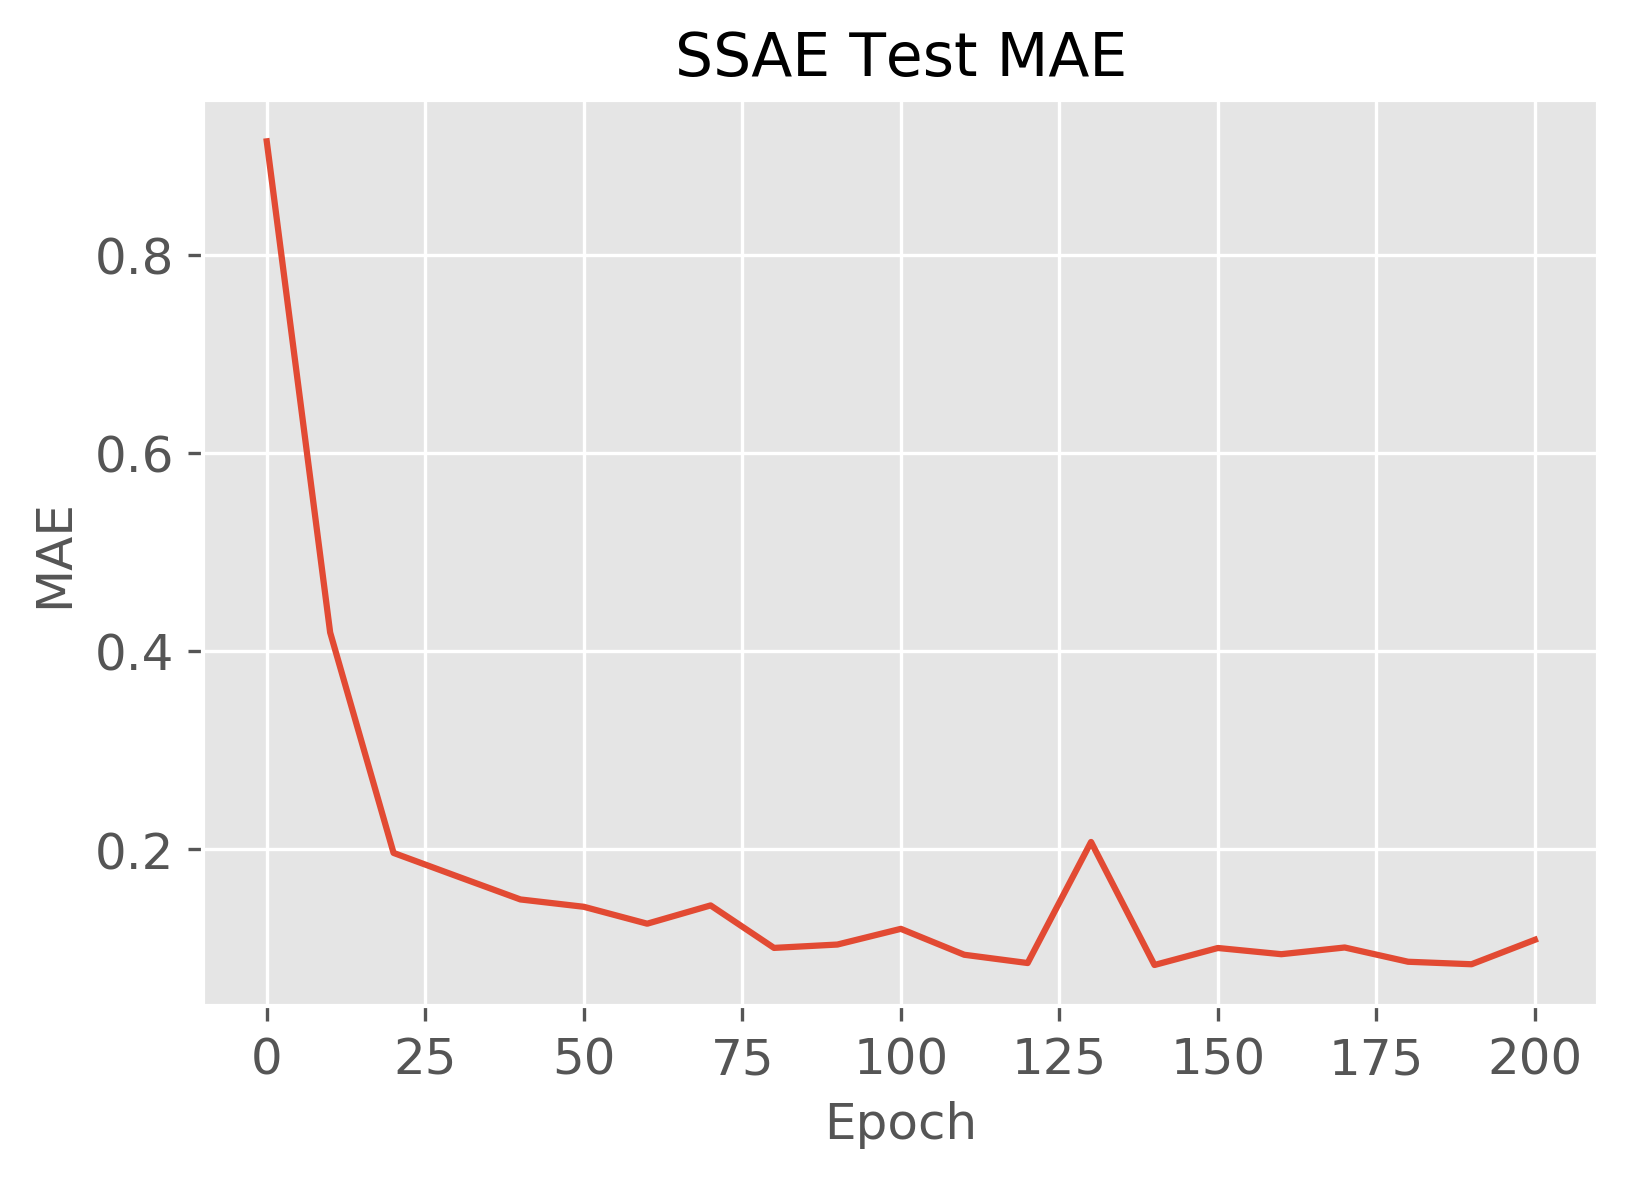

In [1586]:
epoch = [x*10 for x in range(21)]
plt.figure(dpi=300)
plt.plot(epoch, epoch_mae)
plt.title('SSAE Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')

Text(0, 0.5, 'Loss')

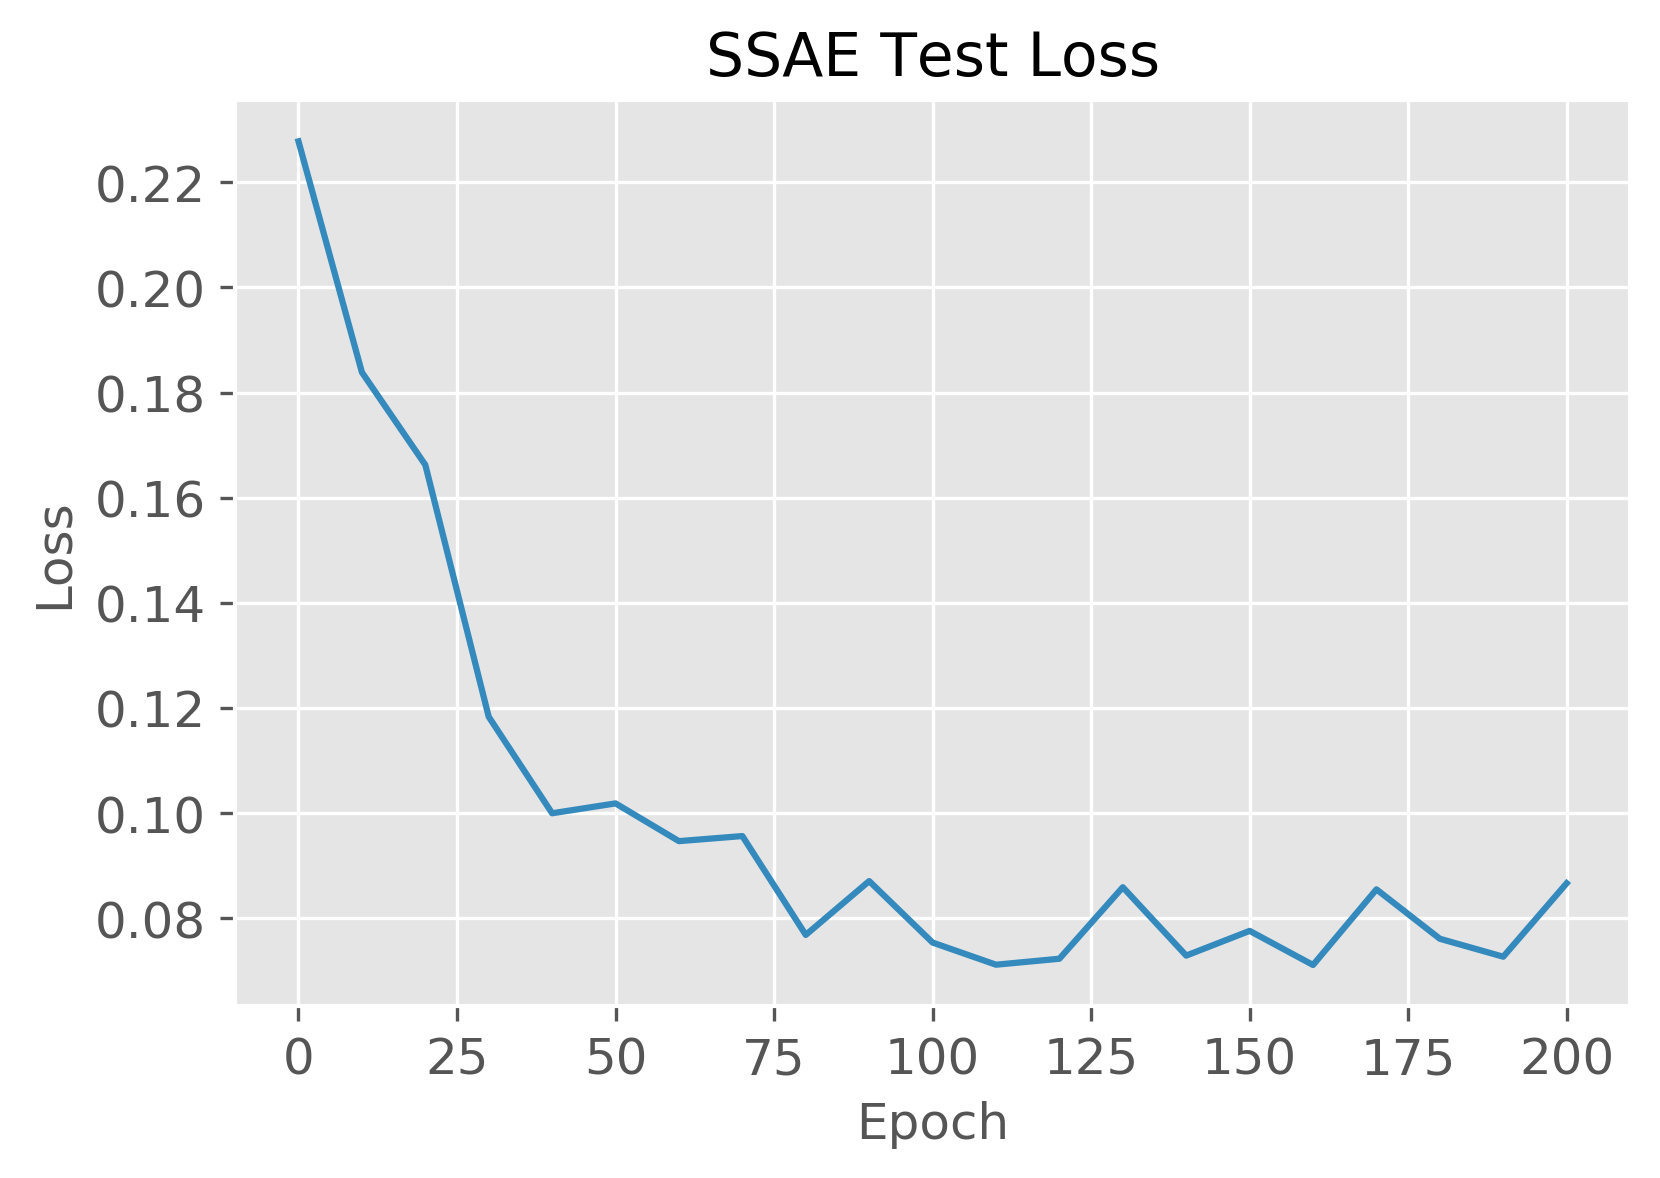

In [1589]:
epoch = [x*10 for x in range(21)]
plt.figure(dpi=300)
plt.plot(epoch, epoch_loss, c='#348abd')
plt.title('SSAE Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [1567]:
epoch_loss = np.mean([[epoch_i[1][4] for epoch_i in fold_i] for fold_i in hdict[0]], axis=0)  # loss by epoch
epoch_mae = np.mean([[epoch_i[1][5] for epoch_i in fold_i] for fold_i in hdict[0]], axis=0)  # mae by loss

In [6]:
print('test mae',
      np.mean([min([epoch_i[1][4] for epoch_i in fold_i]) for fold_i in hdict[0]]), # test mae mean
      np.std([min([epoch_i[1][4] for epoch_i in fold_i]) for fold_i in hdict[0]]))  # test mae std

test mae 0.039100103 0.01834959


In [1010]:
print('test loss',
      np.mean([min([epoch_i[1][5] for epoch_i in fold_i]) for fold_i in hdict[0]]), # test loss mean
      np.std([min([epoch_i[1][5] for epoch_i in fold_i]) for fold_i in hdict[0]]))  # test loss std

test loss 0.07944836 0.028133929


In [5]:
print('test loss',
      np.mean([min([epoch_i[1][5] for epoch_i in fold_i]) for fold_i in hdict[0]]), # test loss mean
      np.std([min([epoch_i[1][5] for epoch_i in fold_i]) for fold_i in hdict[0]]))  # test loss std

test loss 0.044240594 0.020468783


In [45]:
def get_epoch_min_loss(hdict, fold_num, in_fold_num): 
    min_loss = 1000
    min_epoch = 0
    for fold_i in hdict[0]:
        for epoch_test in [epoch_i[1] for epoch_i in fold_i]:  # test만 선택
            if epoch_test[1] == fold_num and epoch_test[2] == in_fold_num:
                if epoch_test[5] < min_loss:  # 5: loss
                    min_loss = epoch_test[5]
                    min_epoch = epoch_test[0]
    return min_epoch

def get_epoch_max_loss(hdict, fold_num, in_fold_num): 
    max_loss = 0
    max_epoch = 0
    for fold_i in hdict[0]:
        for epoch_test in [epoch_i[1] for epoch_i in fold_i]:  # test만 선택
            if epoch_test[1] == fold_num and epoch_test[2] == in_fold_num:
                if epoch_test[5] > max_loss:  # 5: loss
                    max_loss = epoch_test[5]
                    max_epoch = epoch_test[0]
    return max_epoch

def get_epoch_min_mae(hdict, hparam, fold_num, in_fold_num): 
    min_mae = 1000
    min_epoch = 0
    for fold_i in [hdict_param for hdict_param in hdict.values() if hdict_param[0][0][0][3] == hparam][0]:
        for epoch_test in [epoch_i[1] for epoch_i in fold_i]:  # test만 선택
            if epoch_test[1] == fold_num and epoch_test[2] == in_fold_num:
                if epoch_test[4] < min_mae:  # 4: mae
                    min_mae = epoch_test[4]
                    min_epoch = epoch_test[0]
    return min_epoch

def get_epoch_max_mae(hdict, fold_num, in_fold_num): 
    max_mae = 0
    max_epoch = 0
    for fold_i in hdict[0]:
        for epoch_test in [epoch_i[1] for epoch_i in fold_i]:  # test만 선택
            if epoch_test[1] == fold_num and epoch_test[2] == in_fold_num:
                if epoch_test[4] > max_mae:  # 4: mae
                    max_mae = epoch_test[4]
                    max_epoch = epoch_test[0]
    return max_epoch

def build_ssae(X_train, hparam):  #  Test 이후 문제 없으면 학습시에도 변경
    ##### Init #####
    reset_graph(random_seed)
    training = tf.placeholder_with_default(False, shape=(), name='training')
    n_inputs = X_train.shape[1]
    n_hidden = 10
    n_outputs = n_inputs

    ##### Build Model #####
    # input
    X_input = tf.placeholder(tf.float32, shape=[None, n_inputs])
    
    # layers
    X_drop = tf.layers.dropout(X_input, hparam['dr'], training=training)  # Input dropout
    hidden2 = tf.layers.dense(X_drop, n_hidden, activation=tf.nn.sigmoid)
    hidden1 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.sigmoid)
    hidden0 = tf.layers.dense(hidden1, 1, activation=tf.nn.sigmoid)
    hidden1r = tf.layers.dense(hidden0, n_hidden, activation=tf.nn.sigmoid)
    hidden2r = tf.layers.dense(hidden1r, n_hidden, activation=tf.nn.sigmoid)
    logits = tf.layers.dense(hidden2r, n_outputs)

    # output
    logits = tf.layers.dense(hidden2r, n_outputs)

    ##### Construct Loss #####
    # sparsity loss
    hidden_mean = tf.reduce_mean([hidden2, hidden1, hidden1r, hidden2r], axis=0)
    sparsity_loss = tf.reduce_sum(kl_divergence(hparam['st'], hidden_mean))

    # mean info  # Use mae as r_loss
    mae = tf.reduce_mean(tf.abs(logits - X_input))
#    mse = tf.reduce_mean(tf.square(logits-X_input))
#    c_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=X_input, logits=logits))  # cross  entropy 

    # Setting
    r_loss = mae

    # Reconstruction Loss
    loss = r_loss + hparam['sw'] * sparsity_loss

    # Optimizer
    optimizer = tf.train.AdamOptimizer(hparam['lr'])
    training_op = optimizer.minimize(loss)
    
    # Execute TF
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    return init, saver, mae, loss, X_input, logits, hidden0

def get_reconstructed(X_feed, logits, hparam, model_path):
    init, saver, _, _, X_input, logits, hidden0 = build_ssae(X_feed, hparam)
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        logits_val = logits.eval(feed_dict={X_input: X_feed})
        return logits_val, X_input, hidden0, saver
    
def get_code_0(X_feed, X_input, hidden0, saver, model_path):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        hidden0_val = hidden0.eval(feed_dict={X_input: X_feed})
        return hidden0_val

In [46]:
bed_train_data, bed_test_data  = build_data(1, None, hparam, with_iid=True)

ValueError: too many values to unpack (expected 2)

In [1312]:
bed_train_data

,IID,1:28875134:A:G_G,1:87968670:A:C_C,1:161477945:C:T_T,2:227817651:A:C_C,3:2436730:C:A_A,3:2439813:A:C_C,3:2526760:G:A_A,3:2543220:C:T_T,3:2549167:G:A_A,...,20:51353834:G:A_G,20:51355272:A:G_G,20:51356520:A:G_G,20:51361284:C:A_C,20:51363417:G:C_G,20:51367978:G:T_G,20:51371580:G:A_A,20:51371657:A:G_G,20:51372200:G:T_T,y
0,KNIHGR000001_KNIHGR000001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,KNIHGR000002_KNIHGR000002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,KNIHGR000005_KNIHGR000005,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,KNIHGR000008_KNIHGR000008,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,KNIHGR000011_KNIHGR000011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,KNIHGR009586_KNIHGR009586,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3133,KNIHGR009593_KNIHGR009593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3134,KNIHGR009594_KNIHGR009594,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3135,KNIHGR009595_KNIHGR009595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1132]:
pred_10_list = []
in_fold_num = None  #최종 결과에 대해서만 예측
for fold_num in range(1, 6):
        X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam)
        pred_val = get_reconstructed(X_test, logits, hparam,
                                       get_bed_path('model_yi_ex', 'test',
                                                    fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                                    model_key=get_model_key(hdict[0][0][0][0][3]), epoch=10))
        pred_df = pd.concat([pd.DataFrame(pred_val.reshape(X_test.shape[0]*X_test.shape[1], 1), columns=['pred']),
               pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1]), columns=['x_test'])], axis=1)
        pred_10_list.append(pred_df)

ValueError: The passed save_path is not a valid checkpoint: /home2/jpark/Projects/prs/model/cv_1_test_y_100_lr0.01st0.5sw0.5dr0.5en100_20

In [1322]:
pred_list = []
code_train_list = []
code_test_list = []

in_fold_num = None  #최종 결과에 대해서만 예측
for fold_num in range(1, 6):
        X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam, with_iid=True)
        X_train_iid = X_train[['IID']]
        X_test_iid = X_test[['IID']]
        X_train = X_train.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
        X_test = X_test.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
        
        pred_val = get_reconstructed(X_test, logits,
                                       get_bed_path('model_yi_ex', 'test',
                                                    fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                                    model_key=get_model_key(hdict[0][0][0][0][3]), epoch=get_epoch_min_loss(hdict, fold_num, in_fold_num)))
        code_train = get_code_0(X_train, logits,
                                get_bed_path('model_yi_ex', 'test',
                                         fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                         model_key=get_model_key(hdict[0][0][0][0][3]), epoch=get_epoch_min_loss(hdict, fold_num, in_fold_num)))
        code_test = get_code_0(X_test, logits,
                               get_bed_path('model_yi_ex', 'test',
                                        fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                        model_key=get_model_key(hdict[0][0][0][0][3]), epoch=get_epoch_min_loss(hdict, fold_num, in_fold_num)))
        pred_df = pd.concat([pd.DataFrame(pred_val.reshape(X_test.shape[0]*X_test.shape[1], 1), columns=['pred']),
               pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1]), columns=['x_test'])], axis=1)
        code_train_df = pd.concat([X_train_iid, pd.DataFrame(code_train, columns=['code']), pd.DataFrame(y_train, columns=['y'])], axis=1)
        code_test_df = pd.concat([X_test_iid, pd.DataFrame(code_test, columns=['code']), pd.DataFrame(y_test, columns=['y'])], axis=1)
        pred_list.append(pred_df)
        code_train_list.append(code_train_df)
        code_test_list.append(code_test_df)

Text(0, 0.5, '')

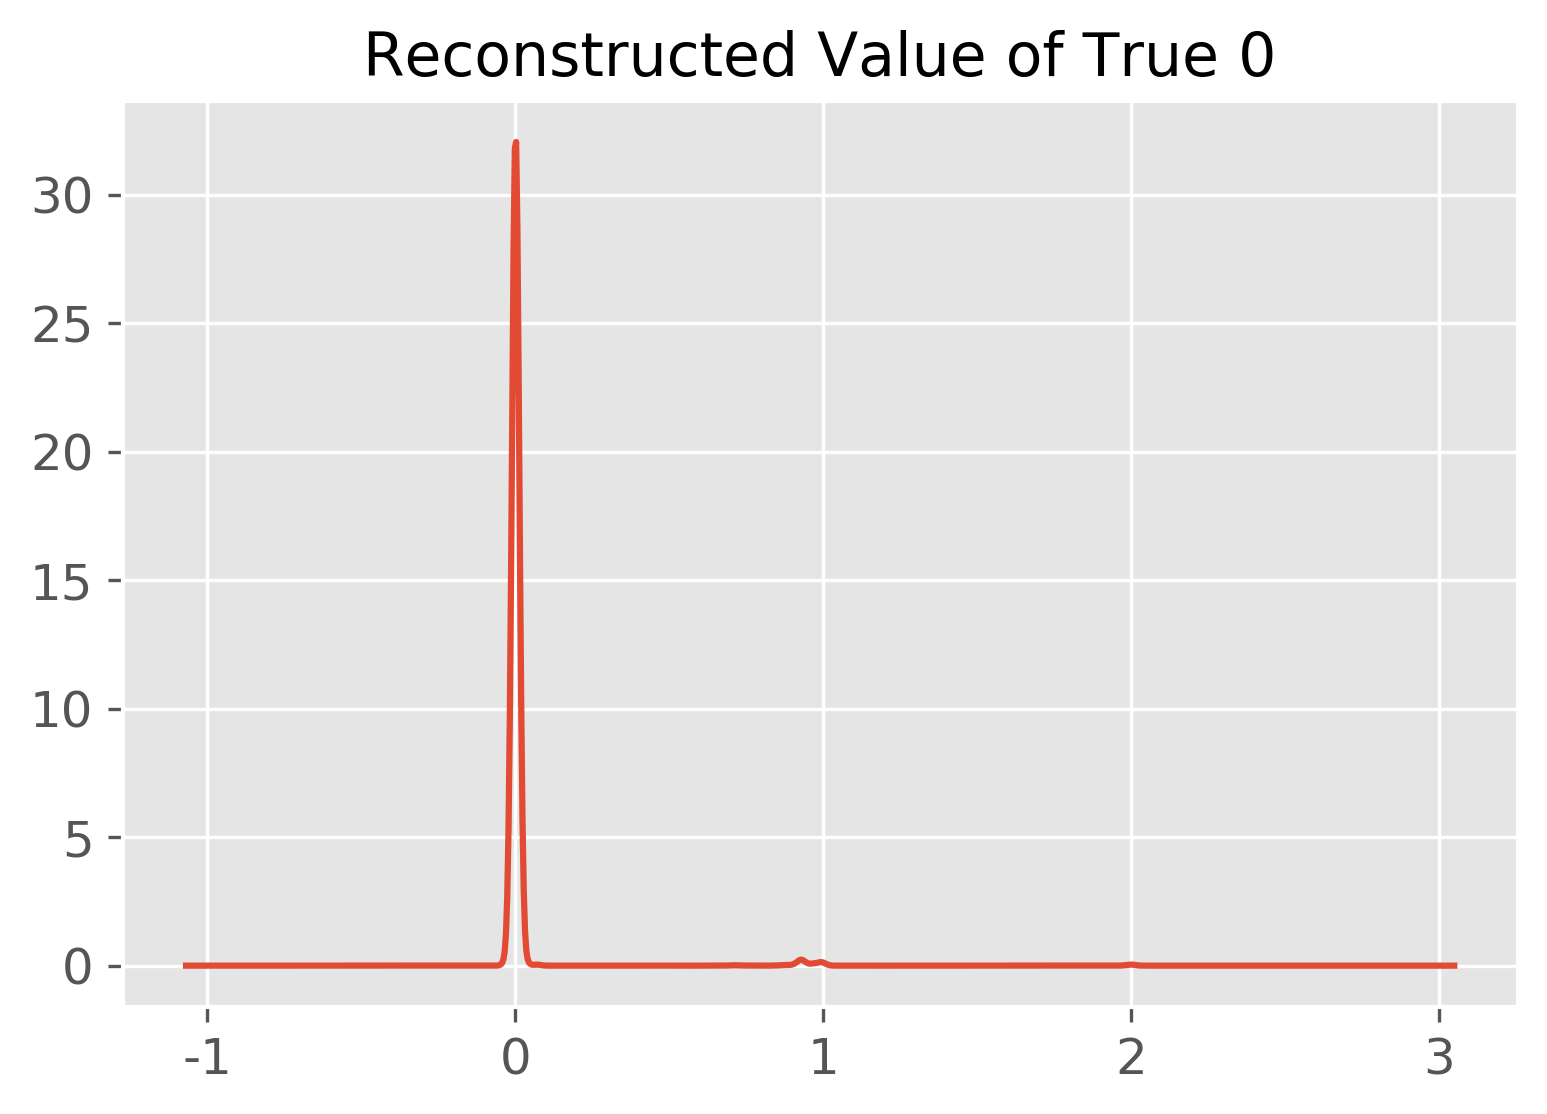

In [1609]:
pred_all = reduce(lambda x, y: pd.concat([x, y]), pred_list)
plt.figure(dpi=300)
pred_all[pred_all['x_test']==0]['pred'].plot.kde()
plt.title('Reconstructed Value of True 0')
plt.ylabel("")

Text(0.5, 0, 'Reconstructed Value')

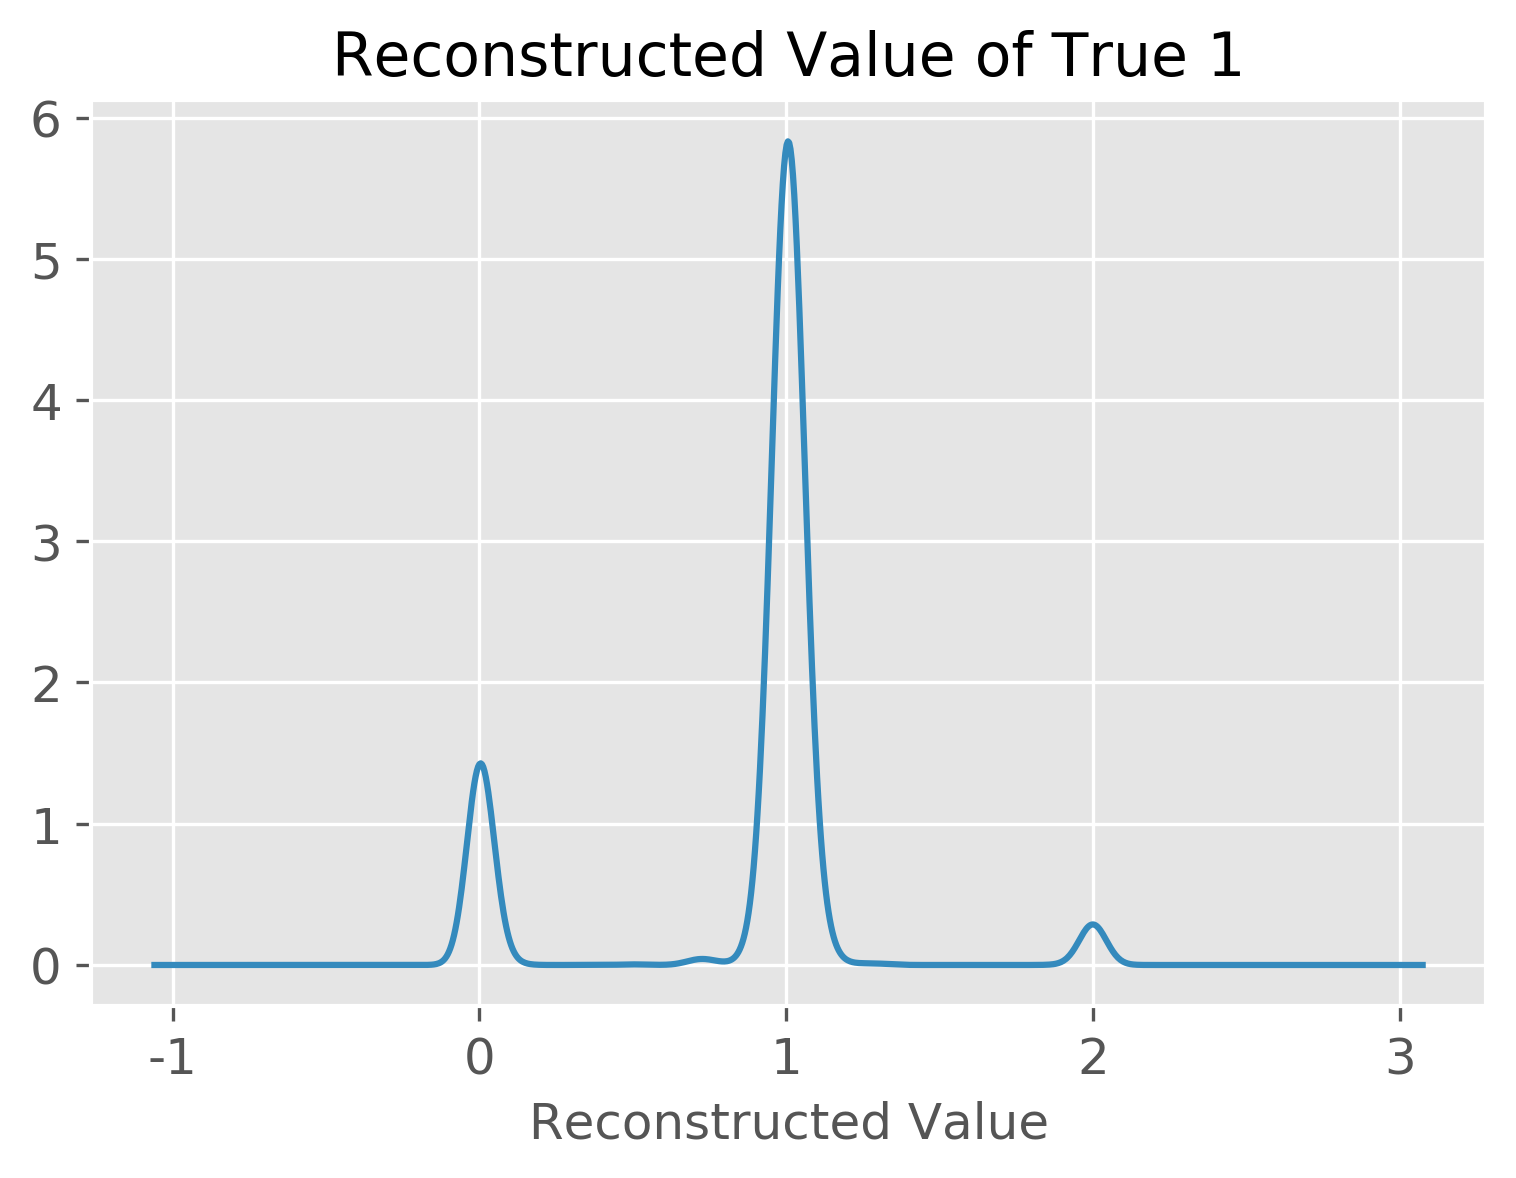

In [1601]:
pred_all = reduce(lambda x, y: pd.concat([x, y]), pred_list)
plt.figure(dpi=300)
pred_all[pred_all['x_test']==1]['pred'].plot.kde(c='#348abd')
plt.title('Reconstructed Value of True 1')
plt.ylabel("")
plt.xlabel('Reconstructed Value')

Text(0, 0.5, '')

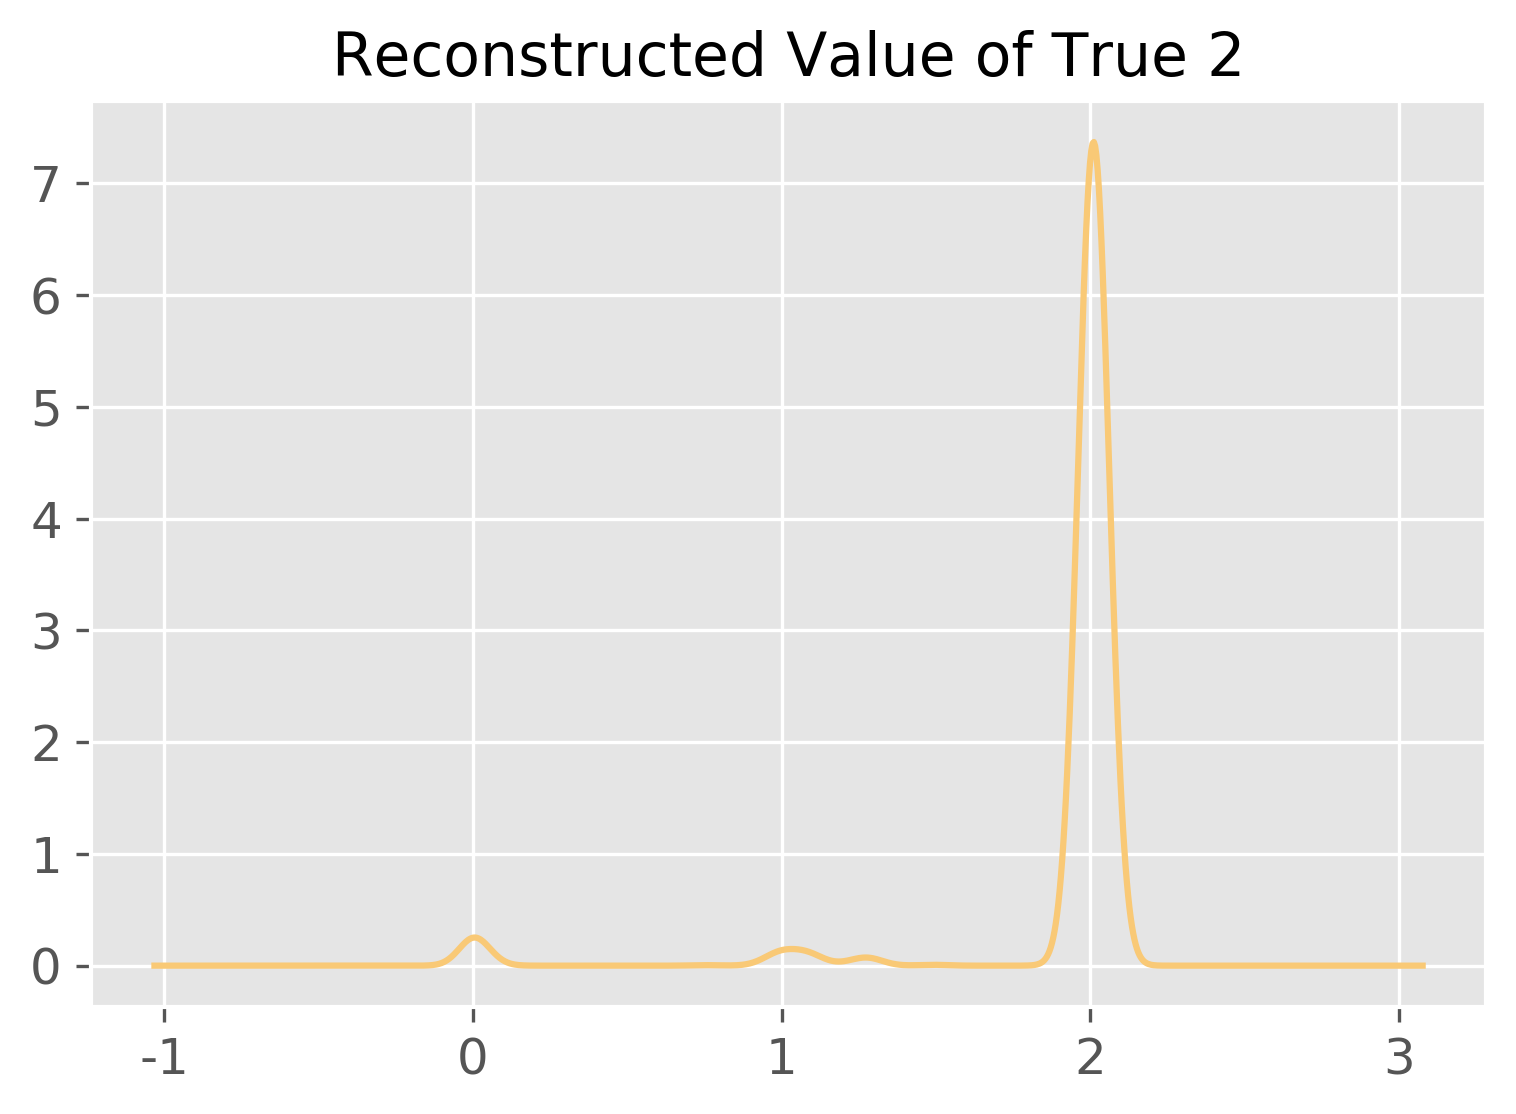

In [1608]:
pred_all = reduce(lambda x, y: pd.concat([x, y]), pred_list)
plt.figure(dpi=300)
pred_all[pred_all['x_test']==2]['pred'].plot.kde(c='#f9c976')
plt.title('Reconstructed Value of True 2')
plt.ylabel("")

# Model build

In [14]:
def get_min_coef(fold_test_result, model_num):
    min_auc = 100
    min_coef = 0
    for fold_i in fold_test_result:
        if min_auc > fold_i[model_num][3]:
            min_auc = fold_i[model_num][3]
            min_coef = fold_i[model_num][4]
    return min_coef

In [225]:
from sklearn.preprocessing import StandardScaler
def create_y_merge_df(train_type, fold_num, ex_num):
    y_value = 'y'
    label_df = pd.read_csv(get_bed_path('label', train_type, fold_num, y=y_value), delim_whitespace=True)
    score_df = pd.read_csv(get_bed_path('score', train_type, fold_num, y=y_value, ex=ex_num), delim_whitespace=True)
    ml_input = label_df.merge(score_df, how='inner', on='IID')[['IID', 'y', 'sex', 'age', 'bmi', 'sbp', 'dbp', 'SCORESUM']].rename(columns={'SCORESUM': f'{y_value}_input'})
    return ml_input

def analyze_model_dict(model_dict, X_train, X_test, y_train, y_test):
    train_result_list = []
    test_result_list = []
    model_list = []
    fitted_result_list = []
    
    for model_name, model in model_dict.items():

        # Train
        fitted_model = model.fit(X_train, y_train)
        model_list.append(fitted_model)
        
        # For train data
        train_pred = fitted_model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_score = precision_recall_fscore_support(y_train, train_pred)
        train_auc = roc_auc_score(y_train, fitted_model.decision_function(X_train))
        train_result_list.append([model_name, train_acc, train_score, train_auc, fitted_model.C_])
       
        # For test data
        test_pred = fitted_model.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)
        test_score = precision_recall_fscore_support(y_test, test_pred)
        test_auc = roc_auc_score(y_test, fitted_model.decision_function(X_test))
        test_result_list.append([model_name, test_acc, test_score, test_auc, fitted_model.C_])
        fitted_result_list.append((y_test, fitted_model.decision_function(X_test)))
        
    return train_result_list, test_result_list, model_list, fitted_result_list

In [219]:
# Create merge df
def build_model(with_cvar, cs_value, code_input=None, ex_num=100):
    fold_train_result = []
    fold_test_result = []
    fold_model_result = []
    fold_fitted_result = []
    for fold_num in range(1, 6):
        if code_input:
            code_train_list = code_input[0]
            code_test_list = code_input[1]
            train_data = create_y_merge_df('train', fold_num, ex_num)
            train_data = train_data.drop('y_input', axis=1)\
                .merge(code_train_list[fold_num-1].drop('y', axis=1).rename(columns={'code': 'y_input'}), on='IID')
            test_data = create_y_merge_df('test', fold_num, ex_num)
            test_data = test_data.drop('y_input', axis=1)\
                .merge(code_test_list[fold_num-1].drop('y', axis=1).rename(columns={'code': 'y_input'}), on='IID')
        else:
            train_data = create_y_merge_df('train', fold_num, ex_num)
            test_data = create_y_merge_df('test', fold_num, ex_num)

        for col in ['y_input']:
            scaler = normalize(train_data, col)
            normalize(test_data, col, scaler)

        # Split
        if with_cvar:
            X_train = train_data[['sex', 'age', 'bmi', 'sbp', 'dbp', 'y_input']]
            X_test = test_data[['sex', 'age', 'bmi', 'sbp', 'dbp', 'y_input']]
        else:
            X_train = train_data[['y_input']]
            X_test = test_data[['y_input']]
    
        y_train = train_data[['y']]
        y_test = test_data[['y']]

        model_dict = {
            'Logistic Ridge': LogisticRegressionCV(penalty='l2', Cs=cs_value[0], scoring='roc_auc', solver='lbfgs',  random_state=random_seed),
            'Logistic Lasso': LogisticRegressionCV(penalty='l1', Cs=cs_value[1], scoring='roc_auc', solver='saga', random_state=random_seed),
        }

        train_result, test_result, model_result, fitted_result = analyze_model_dict(model_dict, X_train, X_test, y_train, y_test)
        fold_train_result.append(train_result)
        fold_test_result.append(test_result)
        fold_model_result.append(model_result)
        fold_fitted_result.append(fitted_result)

    return fold_train_result, fold_test_result, fold_model_result, fold_fitted_result

In [59]:
%%time
#  SNP 갯수에 때한 PRS 모델 비교
l2_list = []
l1_list = []
with_cvar = True
#for ex_num in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
for ex_num in [100]:
    fold_train_result, fold_test_result, fold_model_result, _ = build_model(with_cvar, [5, 5], ex_num=ex_num)
    fold_train_result, fold_test_result, fold_model_result, _ = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                         [get_min_coef(fold_test_result, 1)[0]]], ex_num=ex_num)
    
    print("*****", ex_num, "*****")
    print('test acu ridge',
          np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
    l2_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
    print('test acu lasso',
          np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
    l1_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

***** 100 *****
test acu ridge 0.6725730090007015 0.03313868127275287
test acu lasso 0.6700269595559375 0.03133768186017237
CPU times: user 53.5 s, sys: 1min 21s, total: 2min 15s
Wall time: 6.69 s


In [60]:
model1 = fold_model_result

Text(0, 0.5, 'AUC')

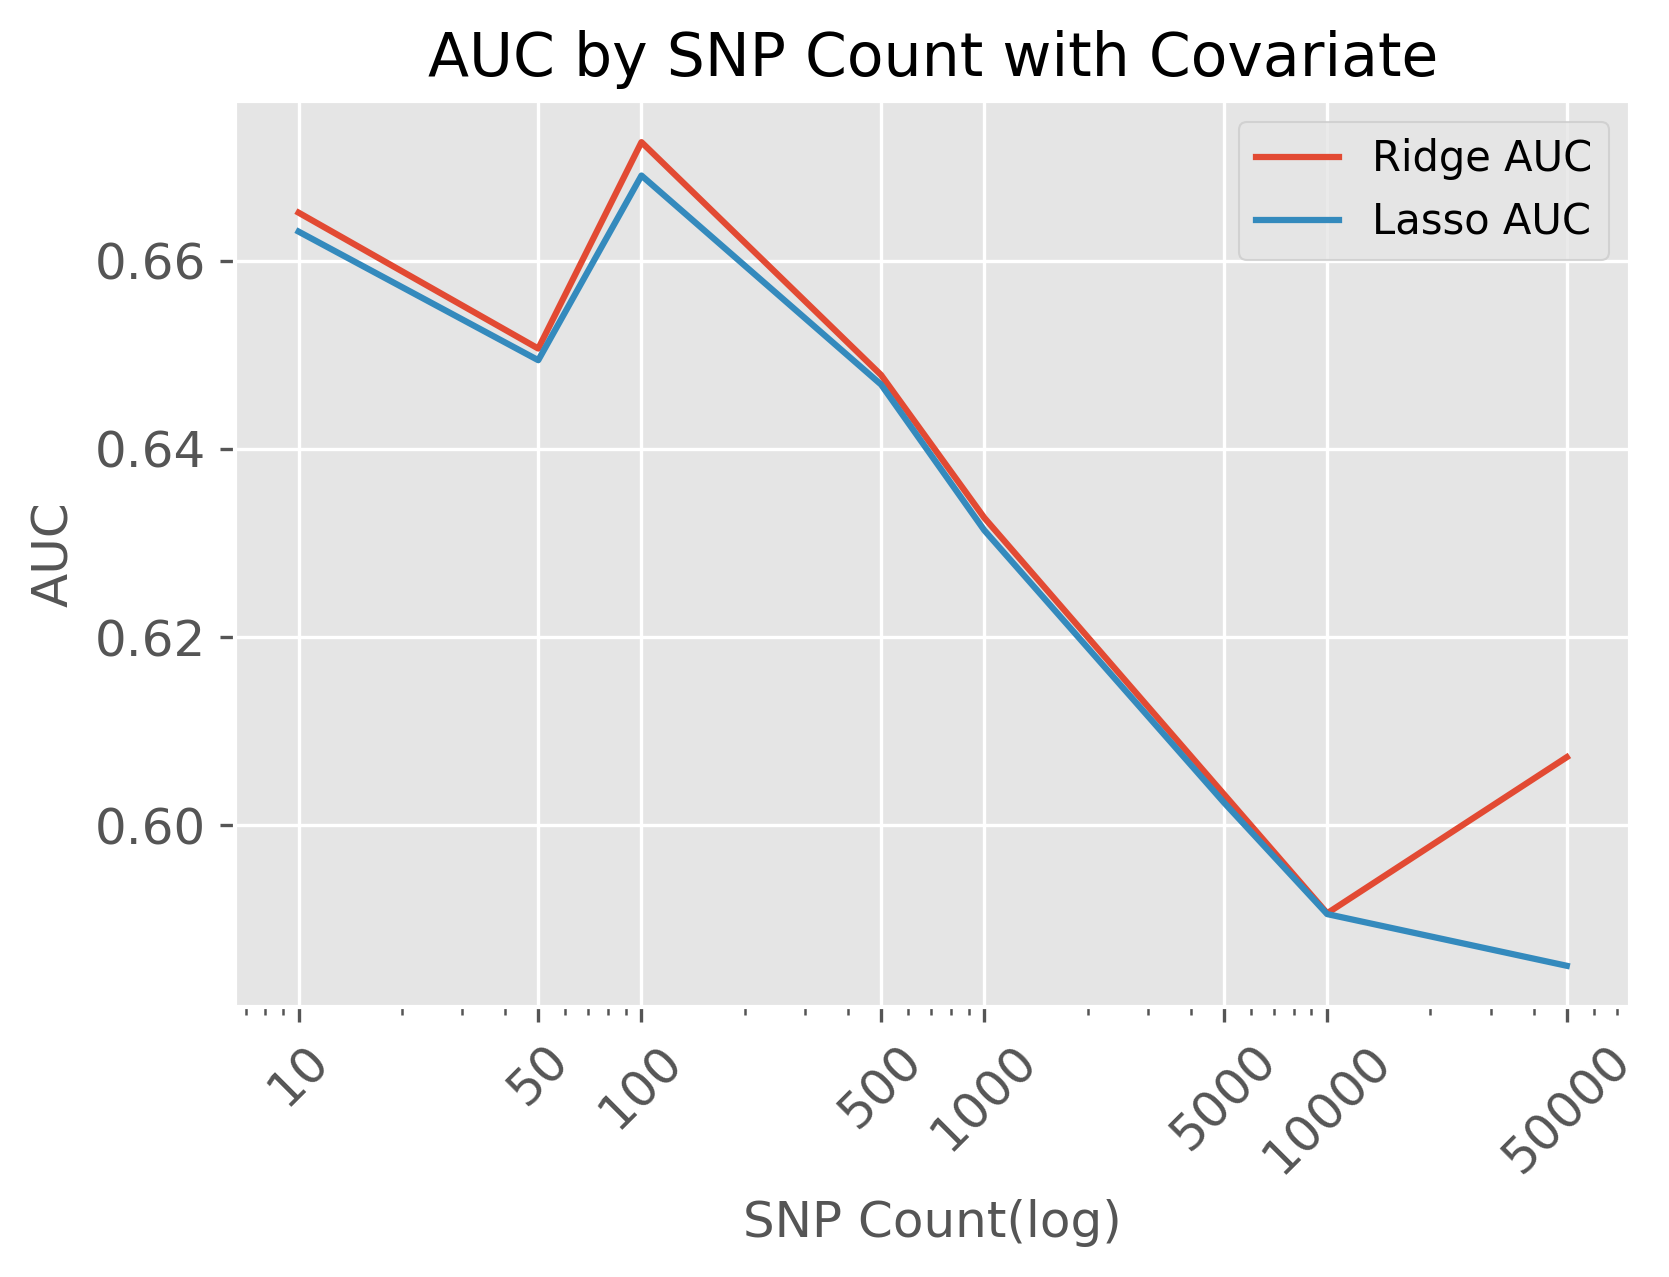

In [1789]:
ex_num = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
plt.figure(dpi=300)
plt.plot(ex_num, l2_list)
plt.plot(ex_num, [auc -1e-3 for auc in l1_list])
plt.legend(['Ridge AUC', 'Lasso AUC'])
plt.xscale('log')
plt.xticks(ex_num, ex_num, rotation=45)
plt.title('AUC by SNP Count with Covariate')
plt.xlabel('SNP Count(log)')
plt.ylabel('AUC')

In [23]:
%%time
#  SNP 갯수에 때한 PRS 모델 비교
l2_list = []
l1_list = []
with_cvar = False
#for ex_num in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
for ex_num in [100]:
    fold_train_result, fold_test_result, fold_model_result, _ = build_model(with_cvar, [5, 5], ex_num=ex_num)
    fold_train_result, fold_test_result, fold_model_result, _ = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                         [get_min_coef(fold_test_result, 1)[0]]], ex_num=ex_num)
    
    print("*****", ex_num, "*****")
    print('test acu ridge',
          np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
    l2_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
    print('test acu lasso',
          np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
    l1_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

***** 100 *****
test acu ridge 0.5520146512339215 0.02887812341816267
test acu lasso 0.5520146512339215 0.02887812341816267
CPU times: user 3.17 s, sys: 71.3 ms, total: 3.24 s
Wall time: 3.24 s


Text(0, 0.5, 'AUC')

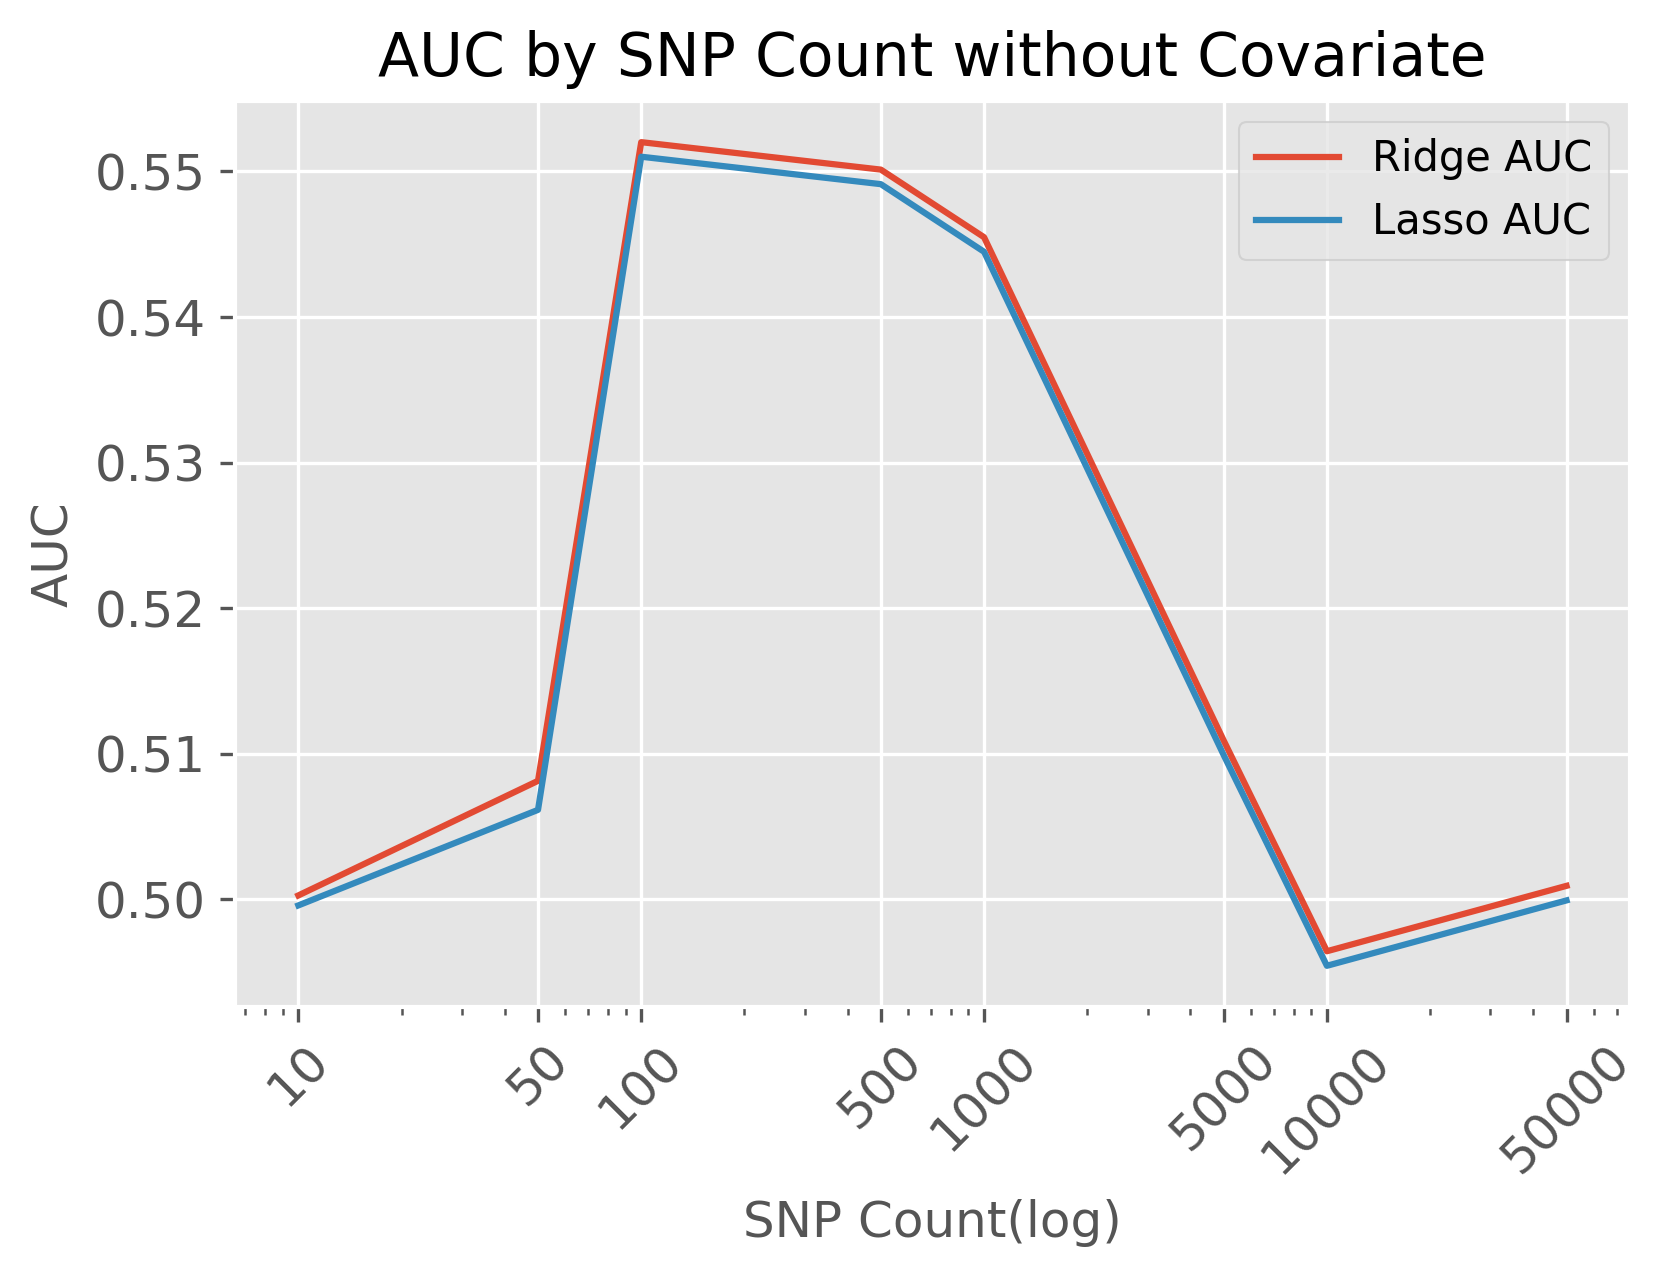

In [1791]:
ex_num = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
plt.figure(dpi=300)
plt.plot(ex_num, l2_list)
plt.plot(ex_num, [auc -1e-3 for auc in l1_list])
plt.legend(['Ridge AUC', 'Lasso AUC'])
plt.xscale('log')
plt.xticks(ex_num, ex_num, rotation=45)
plt.title('AUC by SNP Count without Covariate')
plt.xlabel('SNP Count(log)')
plt.ylabel('AUC')

In [1556]:
0.6698-0.5520

0.1177999999999999

In [1776]:
%%time
# 모델 간의 비교
ridge_wc_list = []
lasso_wc_list = []
with_cvar = True
fold_train_result, fold_test_result, fold_model_result, _ = build_model(with_cvar, [5, 5], ex_num=100)
fold_train_result, fold_test_result, fold_model_result, _ = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                     [get_min_coef(fold_test_result, 1)[0]]], ex_num=100)
print('test acu ridge',
      np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
print('test acu lasso',
      np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
ridge_wc_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
lasso_wc_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

test acu ridge 0.6725730090007015 0.03313868127275287
test acu lasso 0.6700269595559375 0.03133768186017237
CPU times: user 53.1 s, sys: 1min 22s, total: 2min 15s
Wall time: 6.68 s


In [25]:
def get_code_from_ssae(hparam):
    pred_list = []
    code_train_list = []
    code_test_list = []

    in_fold_num = None  #최종 결과에 대해서만 예측
    for fold_num in range(1, 6):
            X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam, with_iid=True)
            X_train_iid = X_train[['IID']]
            X_test_iid = X_test[['IID']]
            X_train = X_train.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
            X_test = X_test.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
            
            pred_val, X_input, hidden0, saver = get_reconstructed(X_test, logits, hparam,
                                           get_bed_path('model_yi_ex', 'test',
                                                        fold_num, in_fold_num=in_fold_num, y=y_value, ex=hparam['en'],
                                                        model_key=get_model_key(hparam), epoch=get_epoch_min_mae(hdict, hparam, fold_num, in_fold_num)))
            code_train = get_code_0(X_train, X_input, hidden0, saver,
                                    get_bed_path('model_yi_ex', 'test',
                                             fold_num, in_fold_num=in_fold_num, y=y_value, ex=hparam['en'],
                                             model_key=get_model_key(hparam), epoch=get_epoch_min_mae(hdict, hparam, fold_num, in_fold_num)))
            code_test = get_code_0(X_test, X_input, hidden0, saver,
                                   get_bed_path('model_yi_ex', 'test',
                                            fold_num, in_fold_num=in_fold_num, y=y_value, ex=hparam['en'],
                                            model_key=get_model_key(hparam), epoch=get_epoch_min_mae(hdict, hparam, fold_num, in_fold_num)))
            pred_df = pd.concat([pd.DataFrame(pred_val.reshape(X_test.shape[0]*X_test.shape[1], 1), columns=['pred']),
                   pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1]), columns=['x_test'])], axis=1)
            code_train_df = pd.concat([X_train_iid, pd.DataFrame(code_train, columns=['code']), pd.DataFrame(y_train, columns=['y'])], axis=1)
            code_test_df = pd.concat([X_test_iid, pd.DataFrame(code_test, columns=['code']), pd.DataFrame(y_test, columns=['y'])], axis=1)
            pred_list.append(pred_df)
            code_train_list.append(code_train_df)
            code_test_list.append(code_test_df)
        
    return pred_list, code_train_list, code_test_list

In [41]:
# Train data
bed_X_train = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)}.raw",
    delim_whitespace=True)
bed_X_train = bed_X_train.iloc[:, [1] + list(range(6, len(bed_X_train.columns)))]
bed_y_train = pd.read_csv(get_bed_path('label', 'train', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
bed_data_train = bed_X_train.merge(bed_y_train, on='IID')

# Test data
bed_X_test = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)}.raw",
    delim_whitespace=True)
bed_X_test = bed_X_test.iloc[:, [1] + list(range(6, len(bed_X_test.columns)))]
bed_y_test = pd.read_csv(get_bed_path('label', 'test', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
bed_data_test = bed_X_test.merge(bed_y_test, on='IID')

# Data set
X_train = bed_data_train.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
y_train = bed_data_train[y_value].to_numpy().astype(np.int32)
X_test = bed_data_test.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
y_test = bed_data_test[y_value].to_numpy().astype(np.int32)

##### Init #####
reset_graph(random_seed)
training = tf.placeholder_with_default(False, shape=(), name='training')
n_inputs = X_train.shape[1]
n_hidden = n_inputs
n_outputs = n_inputs

##### Build Model #####
# input
X_input = tf.placeholder(tf.float32, shape=[None, n_inputs])

# layers
X_drop = tf.layers.dropout(X_input, dropout_rate, training=training)  # Input dropout
hidden2 = tf.layers.dense(X_drop, n_hidden, activation=tf.nn.sigmoid)
hidden1 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.sigmoid)
hidden0 = tf.layers.dense(hidden1, 1, activation=tf.nn.sigmoid)
hidden1r = tf.layers.dense(hidden0, n_hidden, activation=tf.nn.sigmoid)
hidden2r = tf.layers.dense(hidden1r, n_hidden, activation=tf.nn.sigmoid)
logits = tf.layers.dense(hidden2r, n_outputs)

# output
logits = tf.layers.dense(hidden2r, n_outputs)

In [61]:
%%time
# SNP 갯수에 따른 SSAE 모델 비교
l2_list = []
l1_list = []
with_cvar = True
#for ex_num in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
for ex_num in [100]:
    hparam = {'lr': 0.01, 'st': 0.5, 'sw': 0.5, 'dr': 0.5, 'en': ex_num}
    _, code_train_list, code_test_list = get_code_from_ssae(hparam)
    fold_train_result, fold_test_result, fold_model_result, _ = build_model(with_cvar, [5, 5], [code_train_list, code_test_list])
    fold_train_result, fold_test_result, fold_model_result, _ = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                         [get_min_coef(fold_test_result, 1)[0]]], [code_train_list, code_test_list])
    print('test acu ridge',
          np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
    print('test acu lasso',
          np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
    l2_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
    l1_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

test acu ridge 0.6914847651016436 0.03948206240545613
test acu lasso 0.6902133615254918 0.03301360553877937
CPU times: user 58.3 s, sys: 1min 20s, total: 2min 18s
Wall time: 12.3 s


In [337]:
a = [[1],[2],[3]]
a[1] + a[2]

[2, 3]

# Delong Test

In [322]:
%%time
with_cvar = True
#  SNP 갯수에 때한 PRS 모델 비교
l2_list = []
l1_list = []
#for ex_num in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
for ex_num in [100]:
    fold_train_result, fold_test_result, fold_model_result, fold_fitted_result = build_model(with_cvar, [5, 5], ex_num=ex_num)
    fold_train_result, fold_test_result, fold_model_result, fold_fitted_result = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                         [get_min_coef(fold_test_result, 1)[0]]], ex_num=ex_num)
    
    print("*****", ex_num, "*****")
    print('test acu ridge',
          np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
    l2_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
    print('test acu lasso',
          np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
    l1_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))
    model1_fitted = fold_fitted_result

***** 100 *****
test acu ridge 0.6725730090007015 0.03313868127275287
test acu lasso 0.6700269595559375 0.03133768186017237
CPU times: user 48.2 s, sys: 1min 12s, total: 2min
Wall time: 7.73 s


In [323]:
[x[1][3] for x in fold_test_result]

[0.6374575670061307,
 0.7088292445955793,
 0.7063025210084034,
 0.6566615911686334,
 0.6408838740009404]

In [324]:
np.mean([x[1][3] for x in fold_test_result])

0.6700269595559375

In [325]:
%%time
# SNP 갯수에 따른 SSAE 모델 비교
l2_list = []
l1_list = []
#for ex_num in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
for ex_num in [100]:
    hparam = {'lr': 0.01, 'st': 0.5, 'sw': 0.5, 'dr': 0.5, 'en': ex_num}
    _, code_train_list, code_test_list = get_code_from_ssae(hparam)
    fold_train_result, fold_test_result, fold_model_result, fold_fitted_result = build_model(with_cvar, [5, 5], [code_train_list, code_test_list])
    fold_train_result, fold_test_result, fold_model_result, fold_fitted_result = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                         [get_min_coef(fold_test_result, 1)[0]]], [code_train_list, code_test_list])
    print('test acu ridge',
          np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
    print('test acu lasso',
          np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
    l2_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
    l1_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))
    model2_fitted = fold_fitted_result

test acu ridge 0.6914847651016436 0.03948206240545613
test acu lasso 0.6902133615254918 0.03301360553877937
CPU times: user 51.1 s, sys: 1min 7s, total: 1min 58s
Wall time: 12.8 s


In [326]:
[x[1][3] for x in fold_test_result]

[0.64338551958251,
 0.7247793700914906,
 0.7145858343337336,
 0.7105633802816902,
 0.6577527033380348]

In [327]:
np.mean([x[1][3] for x in fold_test_result])

0.6902133615254918

In [391]:
# Create merge df
def test_delong(model1_fitted, model2_fitted, model_num):
    fold_pv_result = []
    for fold_num in range(1, 6):
        pv = delong_roc_test(model1_fitted[fold_num-1][model_num][0],
                        model1_fitted[fold_num-1][model_num][1],
                        model2_fitted[fold_num-1][model_num][1])
        fold_pv_result.append(pv)

    return fold_pv_result

In [394]:
# Create merge df
def test_delong(model1_fitted, model2_fitted, model_num):
    ground_truth = []
    predictions_one = []
    predictions_two = []
    for fold_num in range(1, 6):
        ground_truth.append(model1_fitted[fold_num-1][model_num][0])
        predictions_one.append(model1_fitted[fold_num-1][model_num][1])
        predictions_two.append(model2_fitted[fold_num-1][model_num][1])
    ground_truth = pd.DataFrame(reduce(lambda x, y: np.concatenate((x, y)), ground_truth))
    predictions_one = reduce(lambda x, y: np.concatenate((x, y)), predictions_one)
    predictions_two = reduce(lambda x, y: np.concatenate((x, y)), predictions_two)
    return delong_roc_test(ground_truth, predictions_one, predictions_two)
#    return ground_truth, predictions_one, predictions_two

In [378]:
model1_fitted[0][1][0]

,y
0,1
1,0
2,0
3,0
4,0
...,...
780,0
781,0
782,0
783,0


In [395]:
result = test_delong(model1_fitted, model2_fitted, 1)

In [397]:
for x in result:
    print(10**x[0])
    
print(np.mean([10**x[0] for x in result]))

0.005126975101233905
0.005126975101233905


In [329]:
for x in result:
    print(10**x[0][0])
    
print(np.mean([10**x[0][0] for x in result]))

0.7619150146888186
0.46210652341831043
0.16681604238509526
0.007658673632463508
0.33944044504199083
0.34758733983333573


Text(0, 0.5, 'AUC')

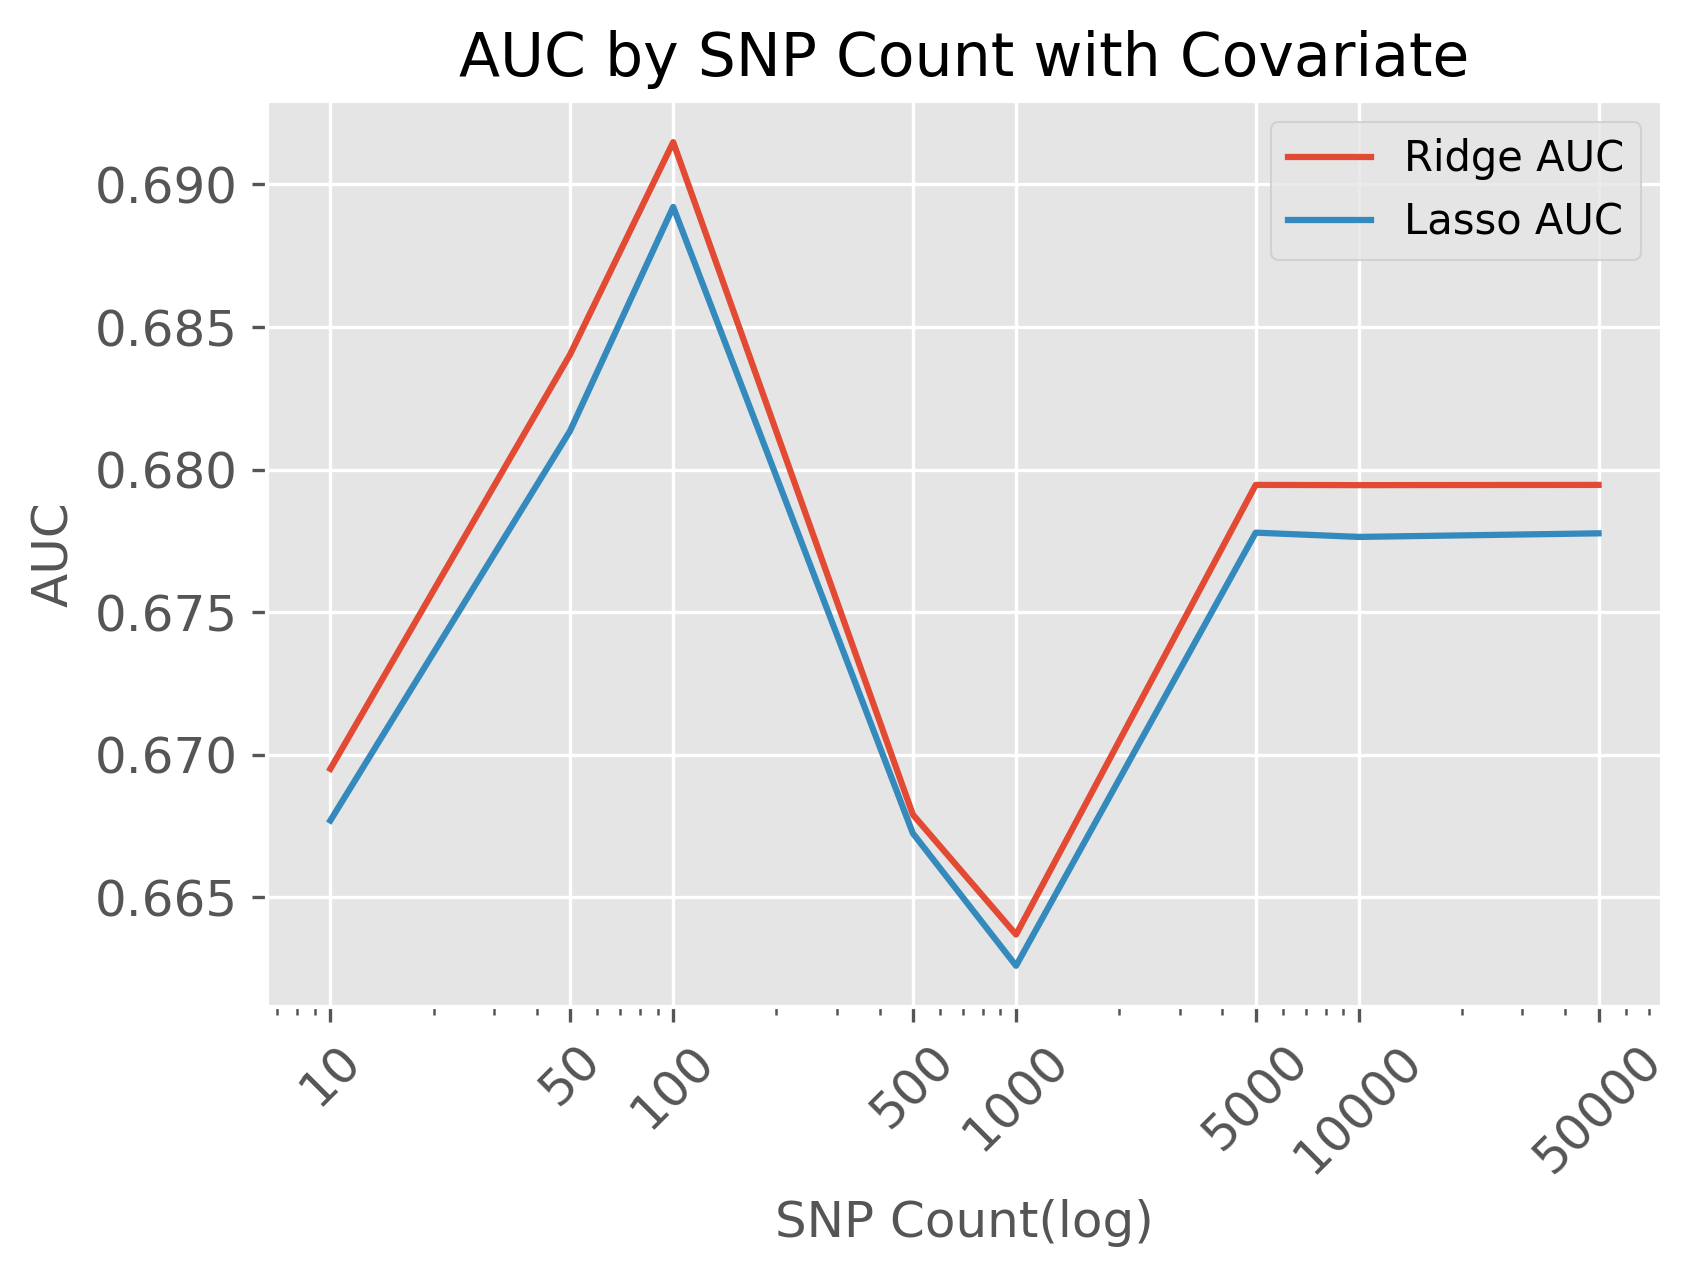

In [1904]:
ex_num = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
plt.figure(dpi=300)
plt.plot(ex_num, l2_list)
plt.plot(ex_num, [auc -1e-3 for auc in l1_list])
plt.legend(['Ridge AUC', 'Lasso AUC'])
plt.xscale('log')
plt.xticks(ex_num, ex_num, rotation=45)
plt.title('AUC by SNP Count with Covariate')
plt.xlabel('SNP Count(log)')
plt.ylabel('AUC')

In [48]:
%%time
# SNP 갯수에 따른 SSAE 모델 비교
l2_list = []
l1_list = []
with_cvar = False
#for ex_num in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
for ex_num in [100]:
    hparam = {'lr': 0.01, 'st': 0.5, 'sw': 0.5, 'dr': 0.5, 'en': ex_num}
    _, code_train_list, code_test_list = get_code_from_ssae(hparam)
    fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [5, 5], [code_train_list, code_test_list])
    fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                         [get_min_coef(fold_test_result, 1)[0]]], [code_train_list, code_test_list])
    print('test acu ridge',
          np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
    print('test acu lasso',
          np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
    l2_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
    l1_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

test acu ridge 0.5592115832027177 0.027388259917574542
test acu lasso 0.5592115832027177 0.027388259917574542
CPU times: user 8.56 s, sys: 278 ms, total: 8.84 s
Wall time: 8.58 s


Text(0, 0.5, 'AUC')

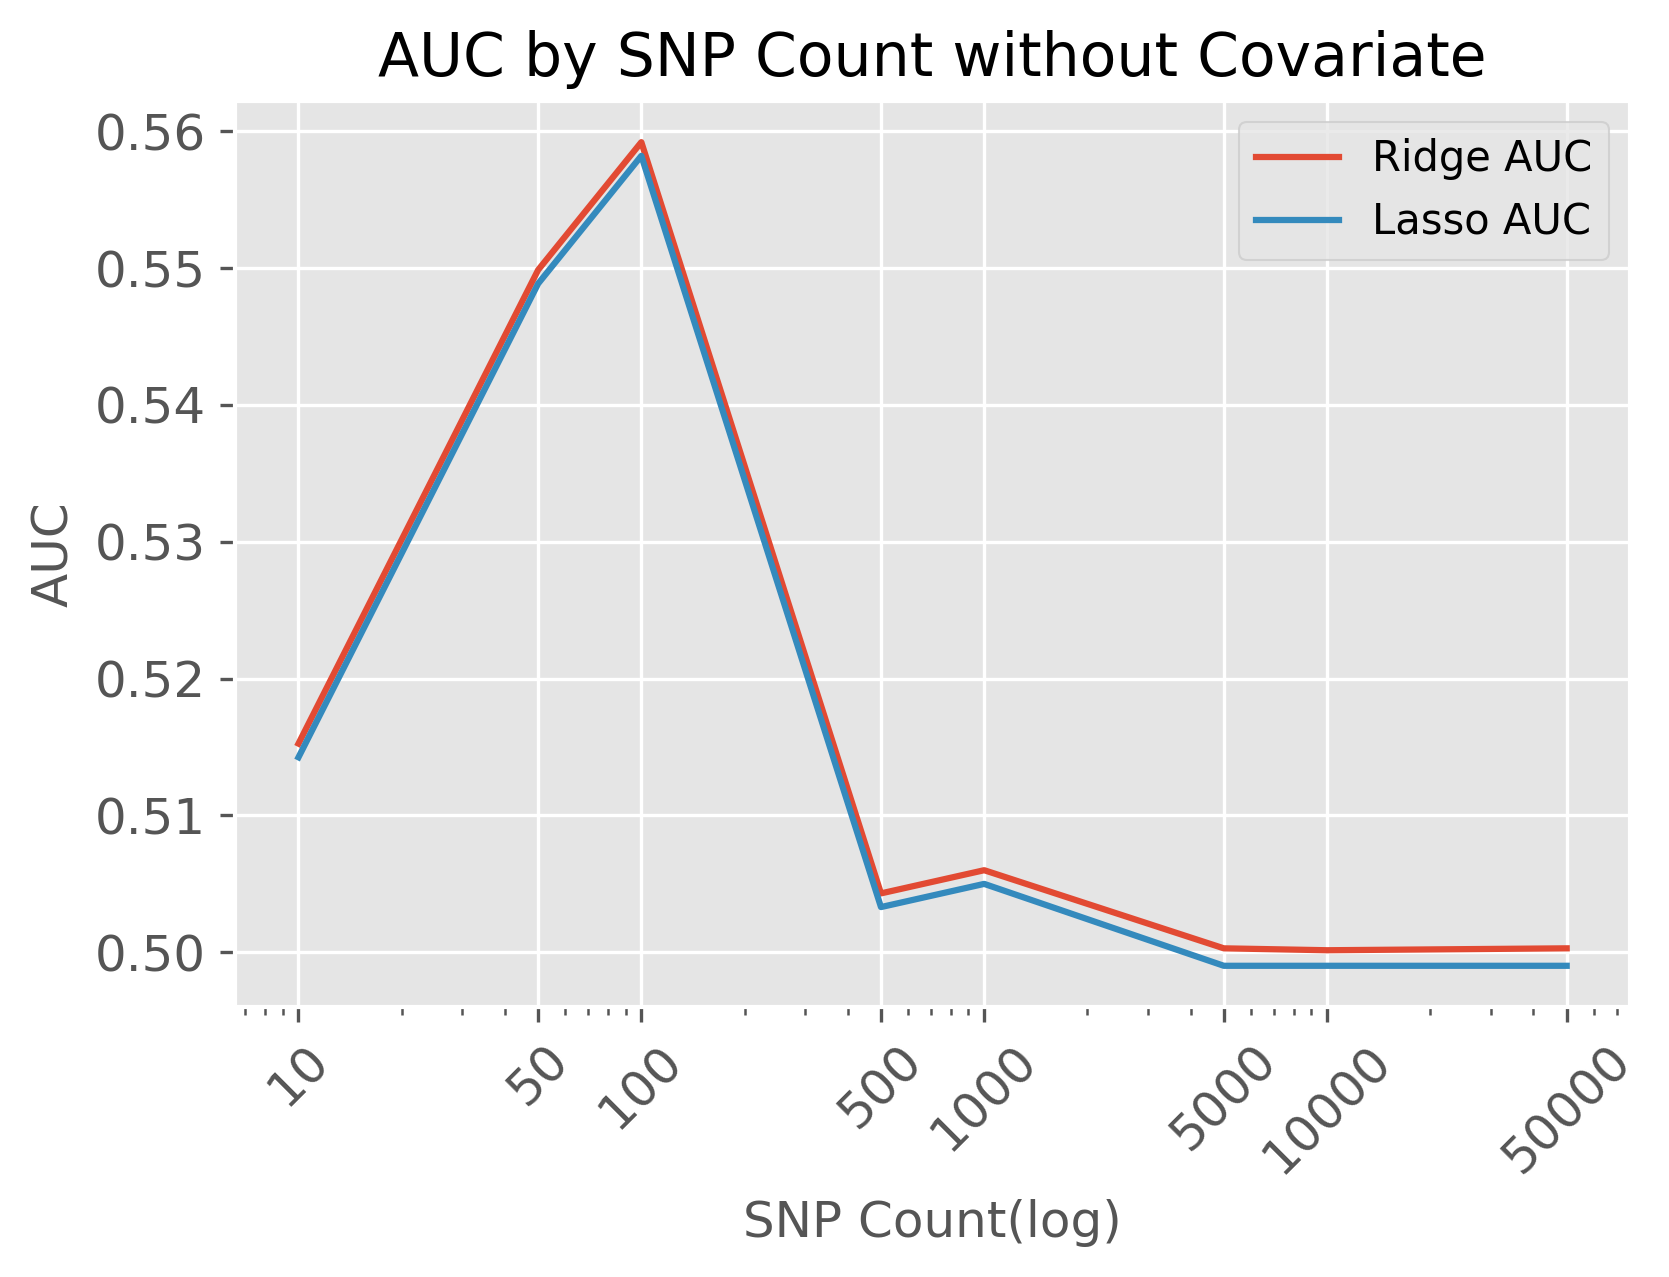

In [1906]:
ex_num = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
plt.figure(dpi=300)
plt.plot(ex_num, l2_list)
plt.plot(ex_num, [auc -1e-3 for auc in l1_list])
plt.legend(['Ridge AUC', 'Lasso AUC'])
plt.xscale('log')
plt.xticks(ex_num, ex_num, rotation=45)
plt.title('AUC by SNP Count without Covariate')
plt.xlabel('SNP Count(log)')
plt.ylabel('AUC')

In [1652]:
0.6909-0.6639

0.026999999999999913

Text(0, 0.5, 'AUC')

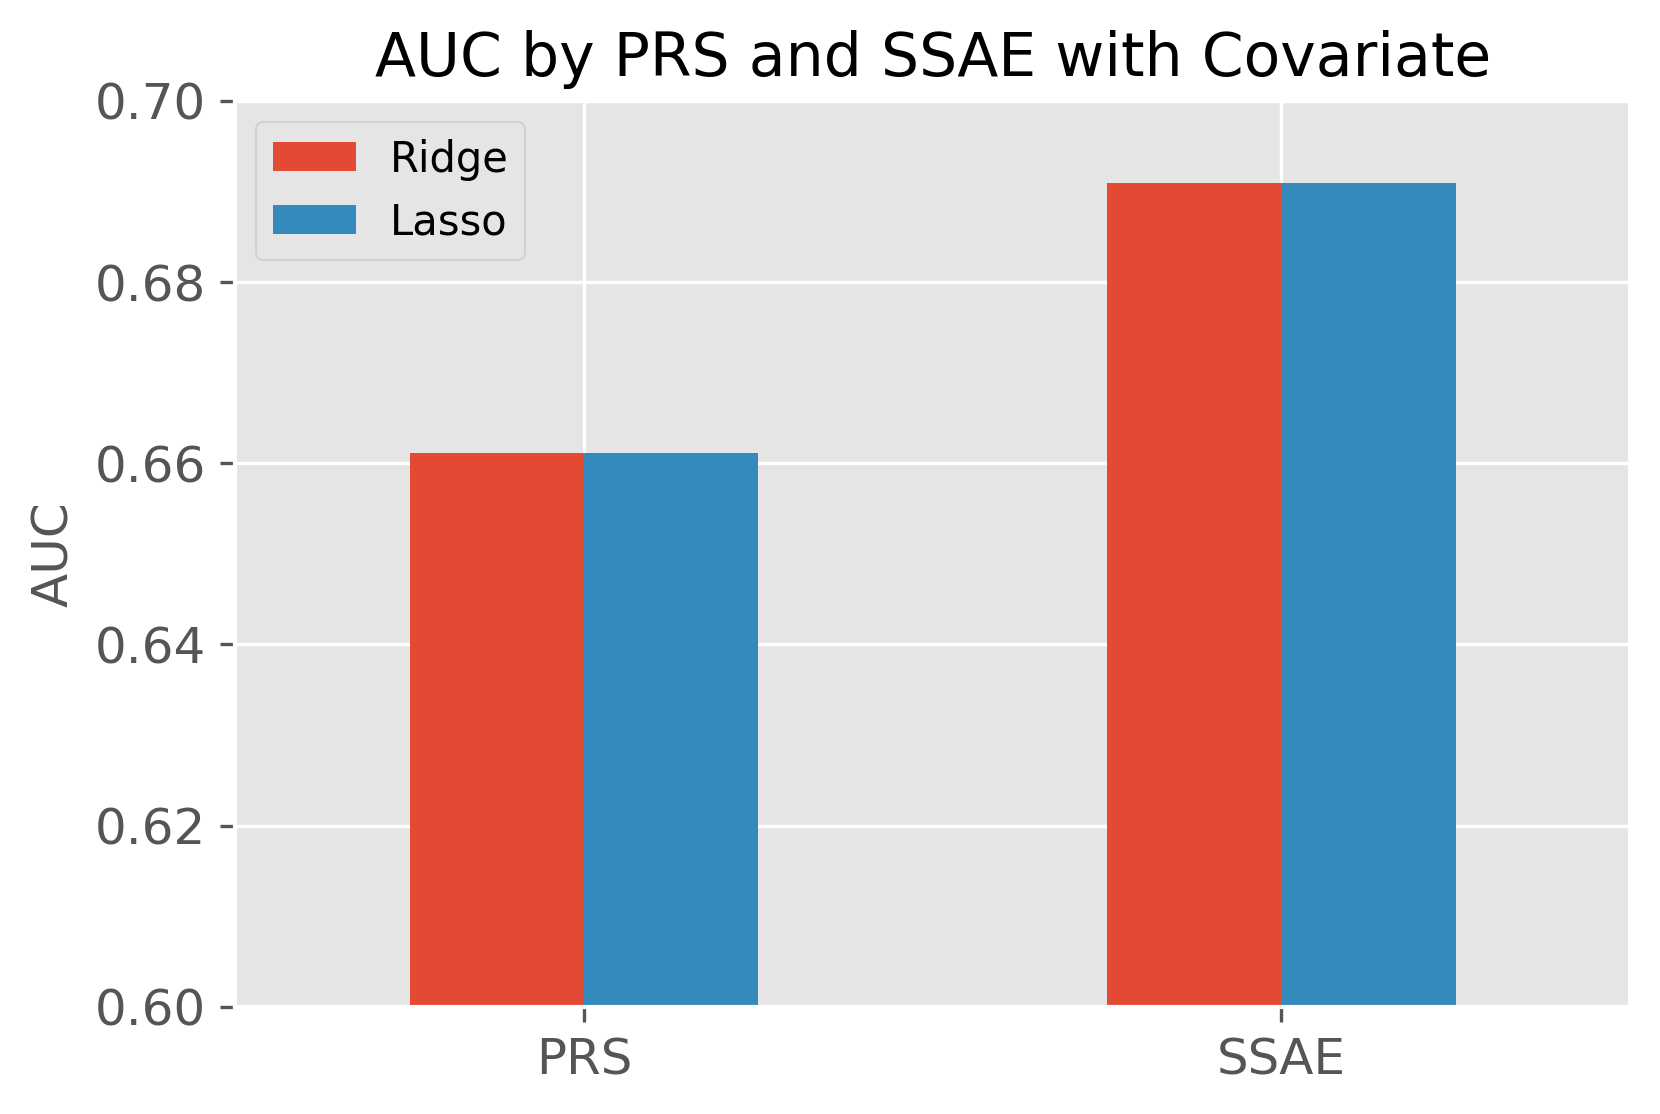

In [1647]:
pd.DataFrame({'Ridge': ridge_wc_list, 'Lasso': ridge_wc_list },
             index=['PRS', 'SSAE']).plot.bar(rot=0)
plt.ylim(0.6, 0.7)
plt.title('AUC by PRS and SSAE with Covariate')
plt.ylabel('AUC')

In [1773]:
%%time
with_cvar = False
for ex_num in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
    [code_train_list, code_test_list]
    fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [5, 5], [code_train_list, code_test_list])
    fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                         [get_min_coef(fold_test_result, 1)[0]]], [code_train_list, code_test_list])
print('test acu ridge',
      np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
print('test acu lasso',
      np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
ridge_wc_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
lasso_wc_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

test acu ridge 0.5698757914814103 0.03857919659411045
test acu lasso 0.5698757914814103 0.03857919659411045
CPU times: user 3.19 s, sys: 0 ns, total: 3.19 s
Wall time: 3.19 s


In [1662]:
0.570 - 0.552

0.017999999999999905

Text(0, 0.5, 'AUC')

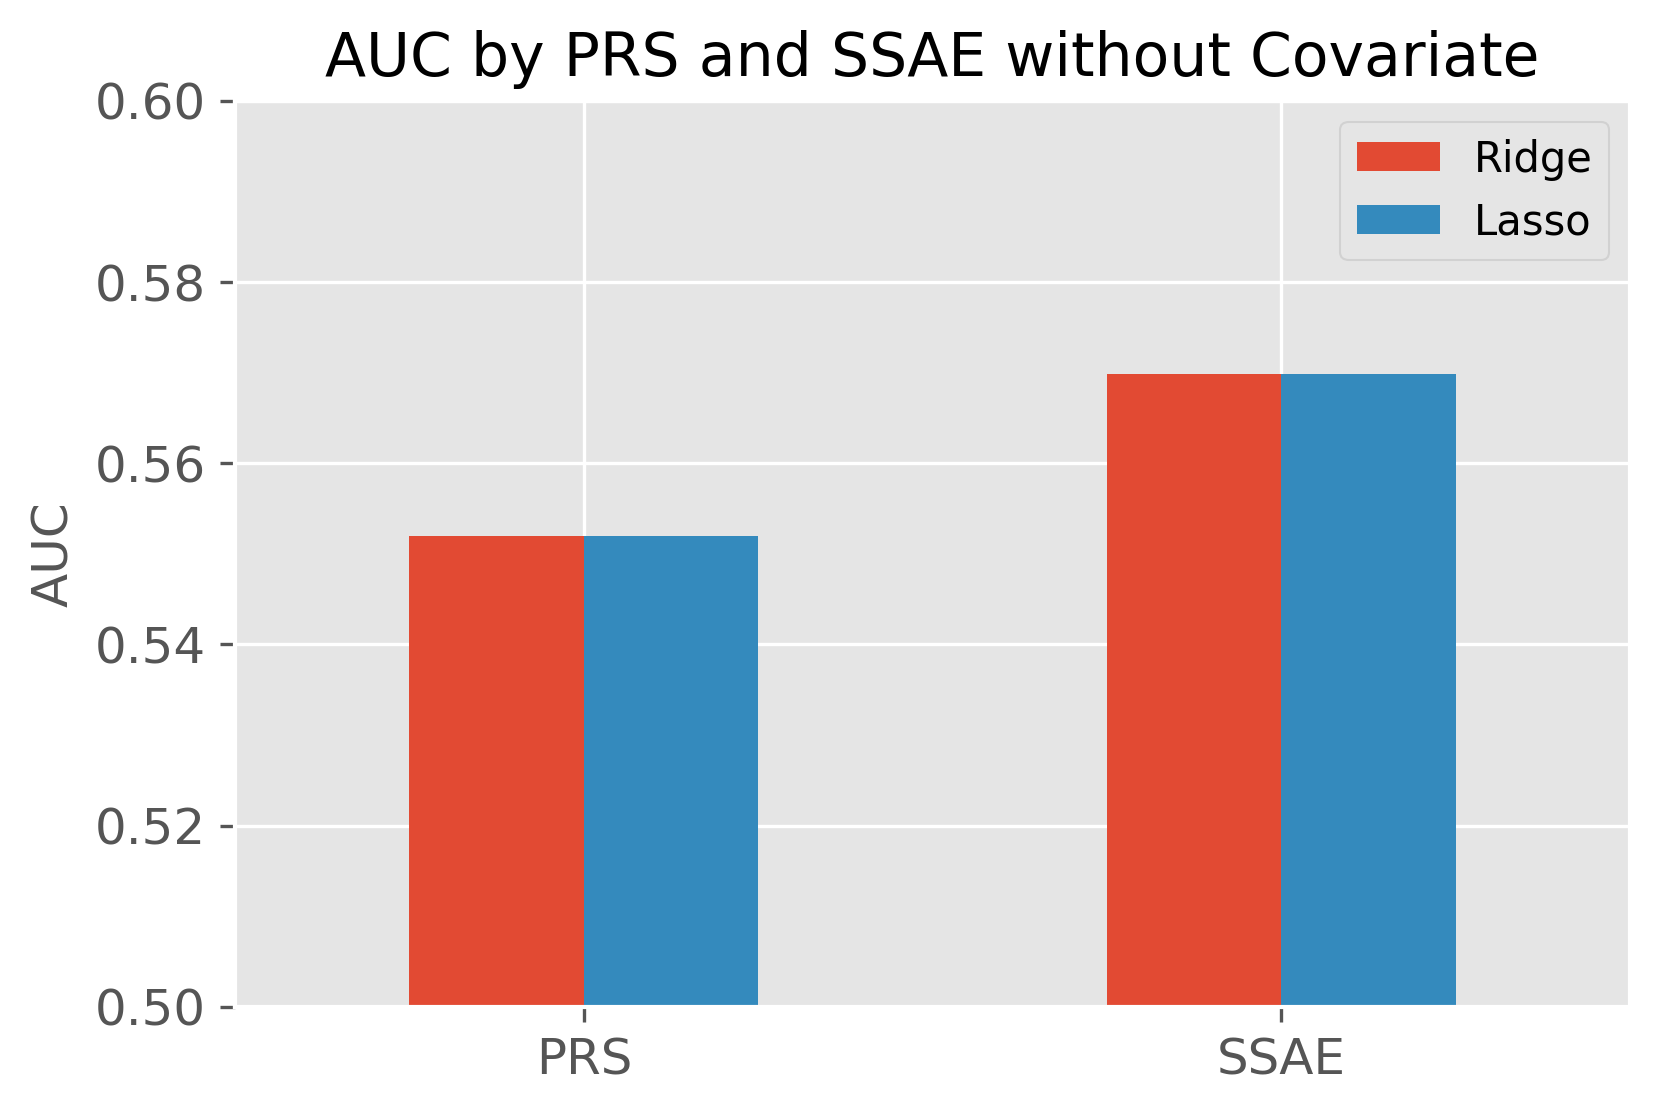

In [1660]:
pd.DataFrame({'Ridge': ridge_wc_list, 'Lasso': ridge_wc_list },
             index=['PRS', 'SSAE']).plot.bar(rot=0)
plt.ylim(0.5, 0.6)
plt.title('AUC by PRS and SSAE without Covariate')
plt.ylabel('AUC')

In [1448]:
test_data_list = []
for fold_num in range(1, 6):
    test_data = create_y_merge_df('test', fold_num, ex_num)
    test_data_list.append(test_data[['y', 'y_input']])
test_data_all = reduce(lambda x, y: pd.concat([x, y]), test_data_list)

In [1423]:
code_test_all = reduce(lambda x, y: pd.concat([x, y]), code_test_list)

Text(0.5, 0, 'Y')

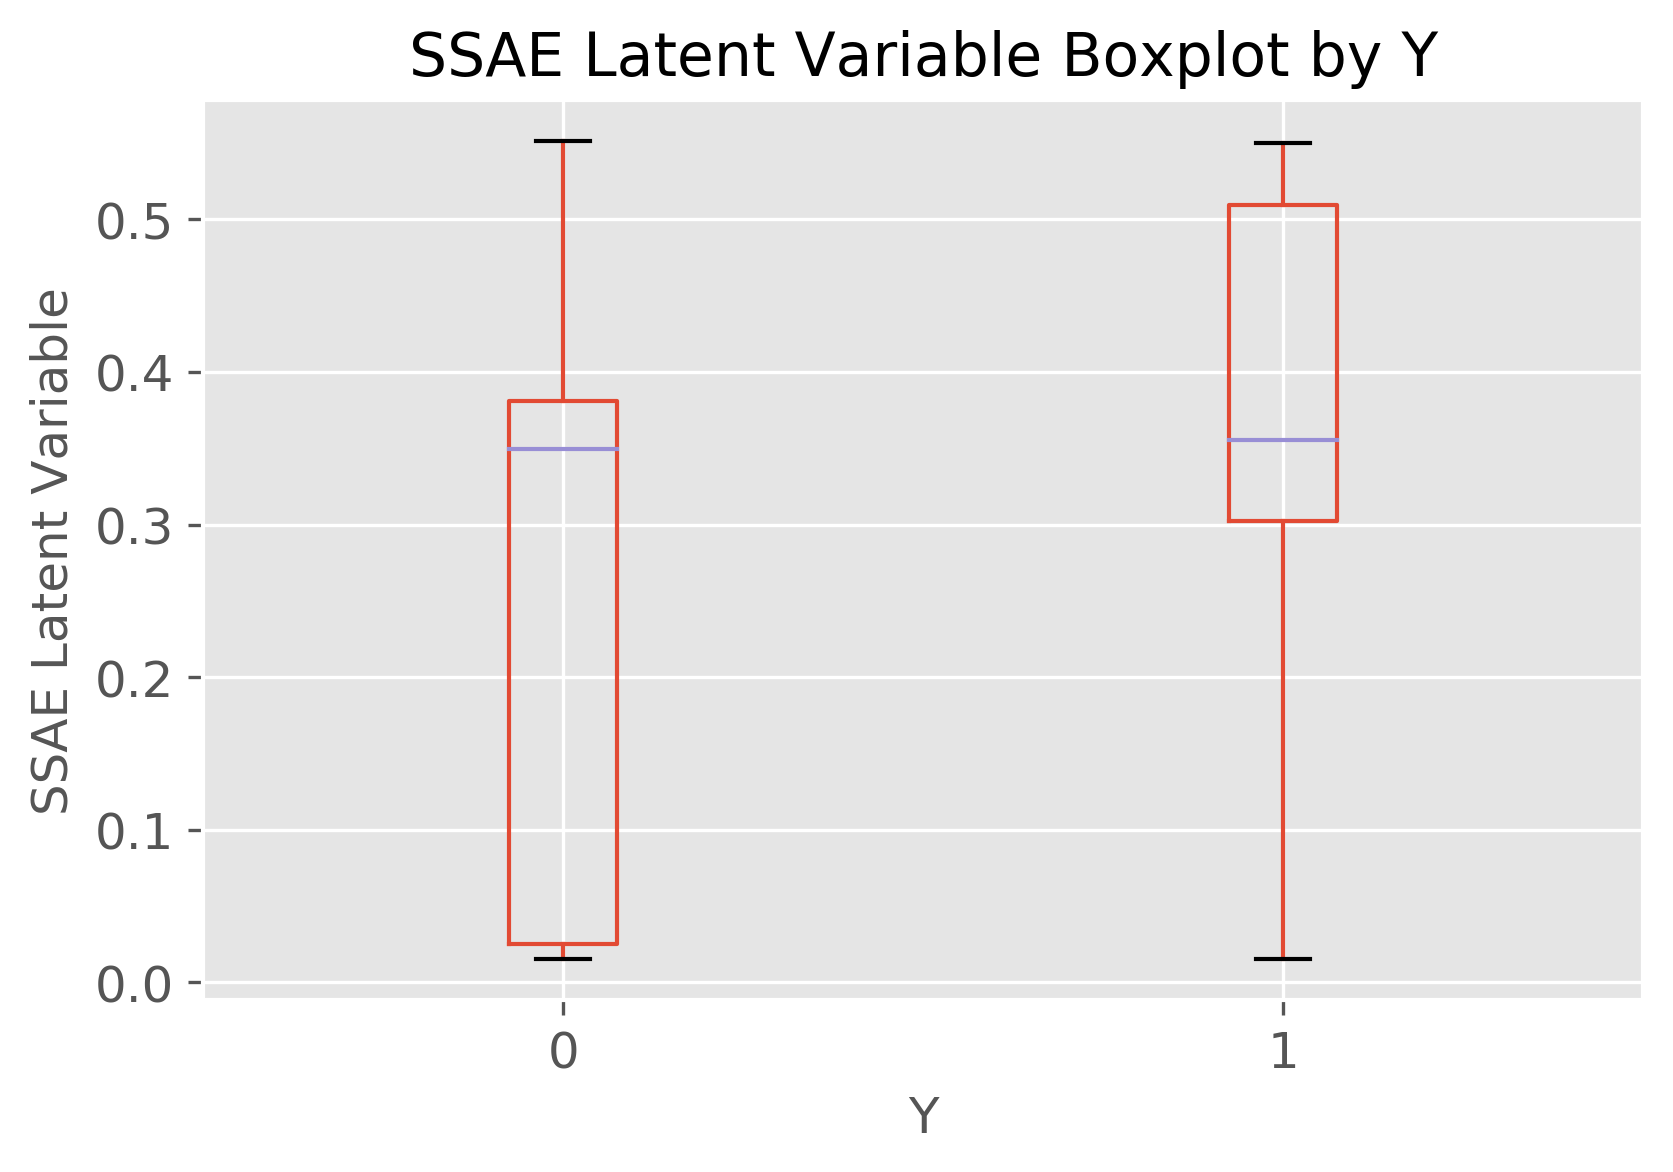

In [1696]:
code_test_all[['code', 'y']].boxplot(by='y')
plt.title('SSAE Latent Variable Boxplot by Y')
plt.suptitle('')
plt.ylabel('SSAE Latent Variable')
plt.xlabel('Y')

Text(0.5, 0, 'Y')

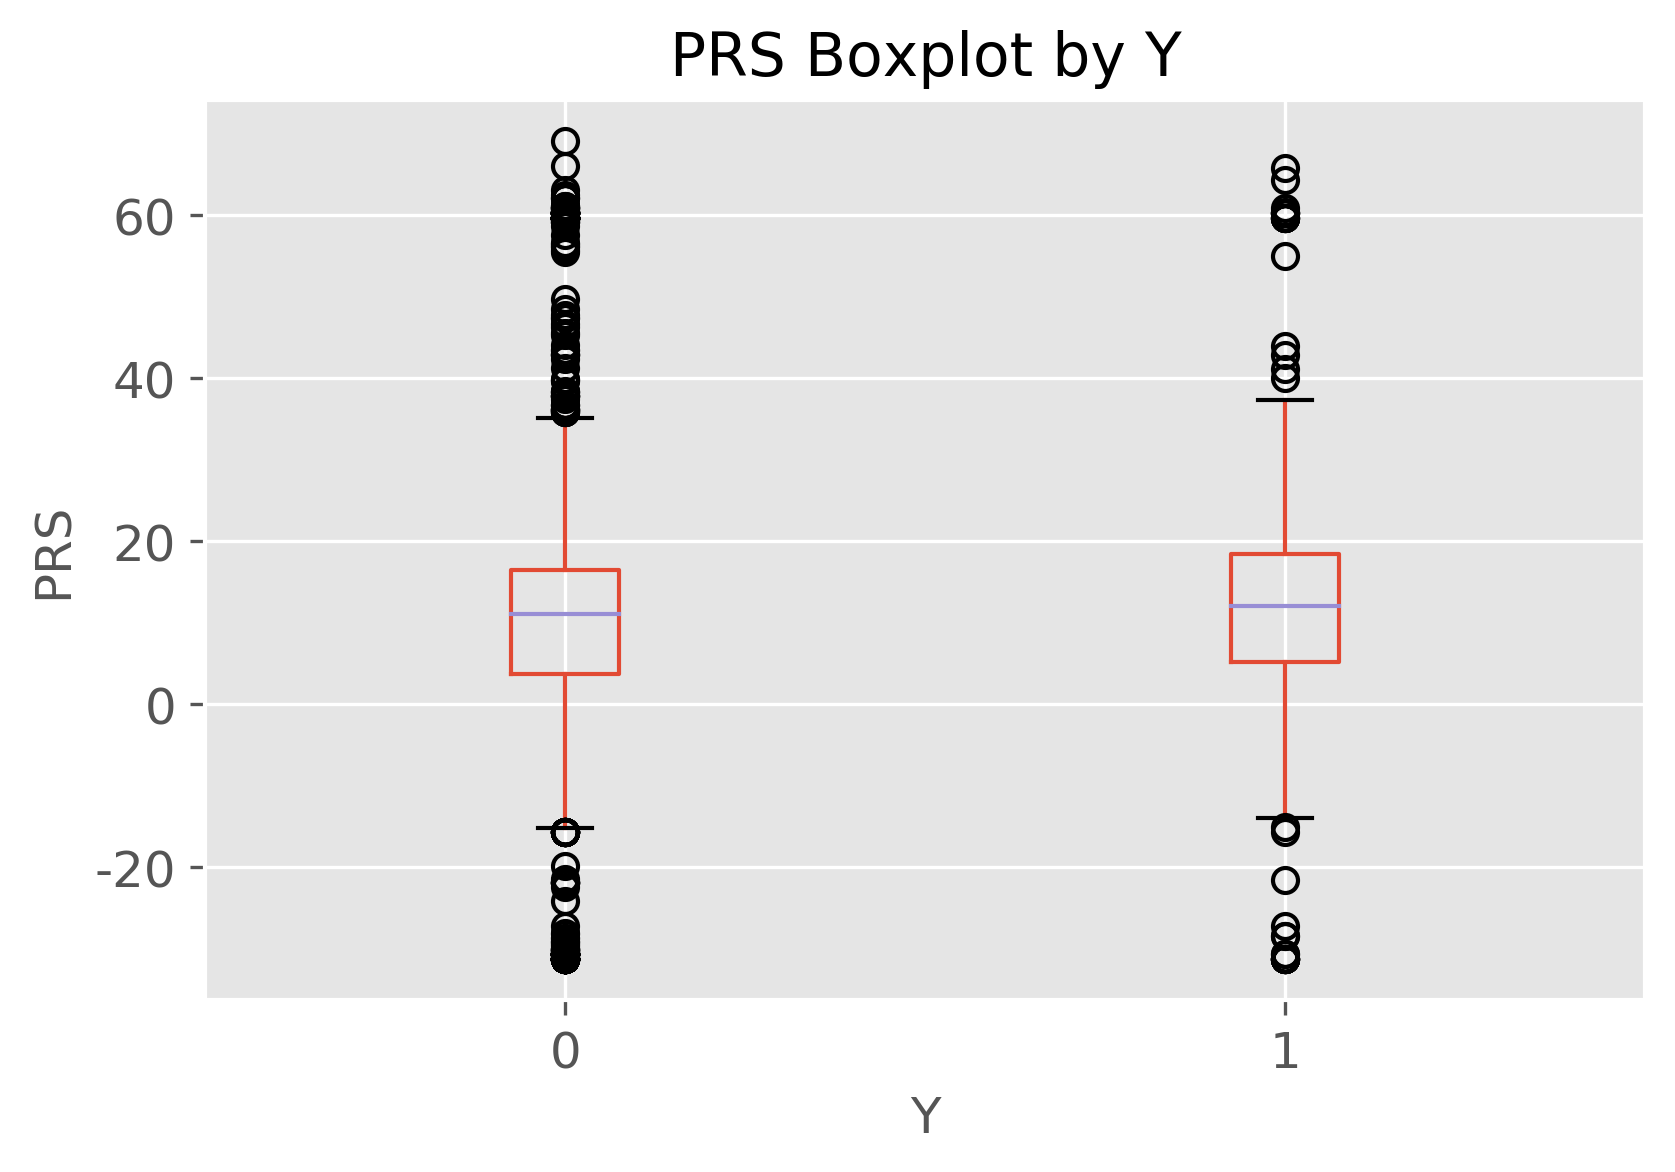

In [1697]:
test_data_all[['y_input', 'y']].boxplot(by='y')
plt.title('PRS Boxplot by Y')
plt.suptitle('')
plt.ylabel('PRS')
plt.xlabel('Y')

In [1679]:
pd.DataFrame({'Y=0': code_test_all[code_test_all['y']==0][['code']],
              'Y=1': code_test_all[code_test_all['y']==1][['code']]}).plot.bar(rot=0)
#plt.ylim(0.5, 0.6)
#plt.title('AUC by PRS and SSAE without Covariate')
#plt.ylabel('AUC')

ValueError: If using all scalar values, you must pass an index

(0, 0.6)

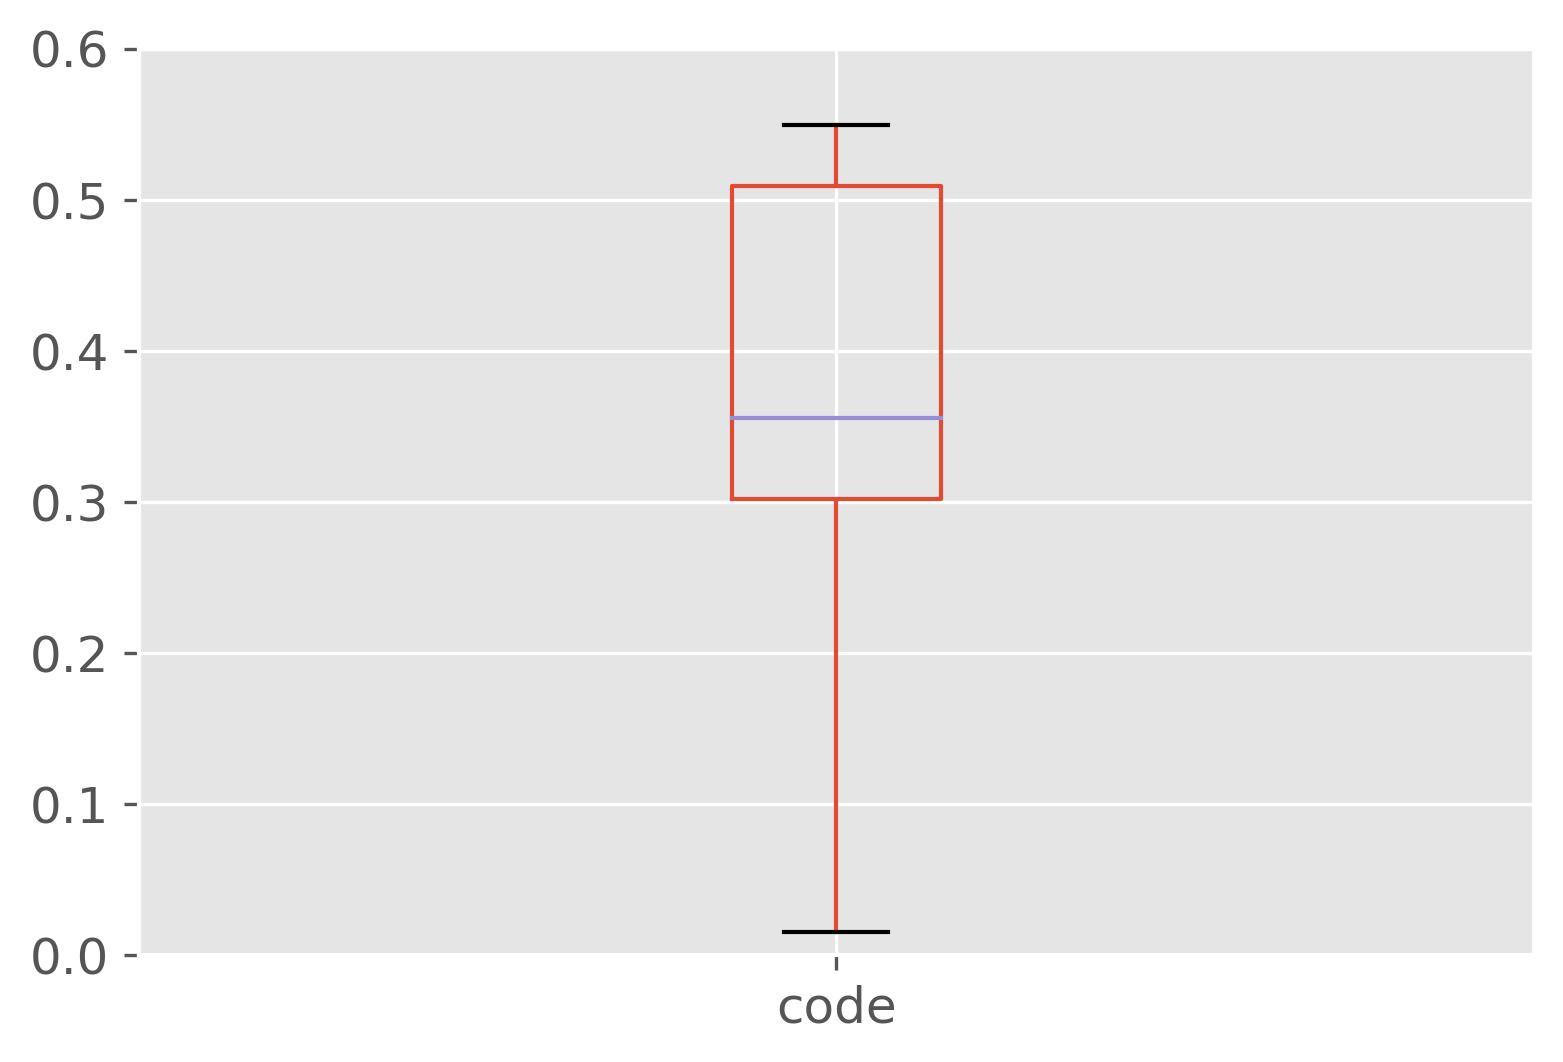

In [1663]:
code_test_all[code_test_all['y']==1][['code']].boxplot()
plt.ylim(0, 0.6)

(0, 0.6)

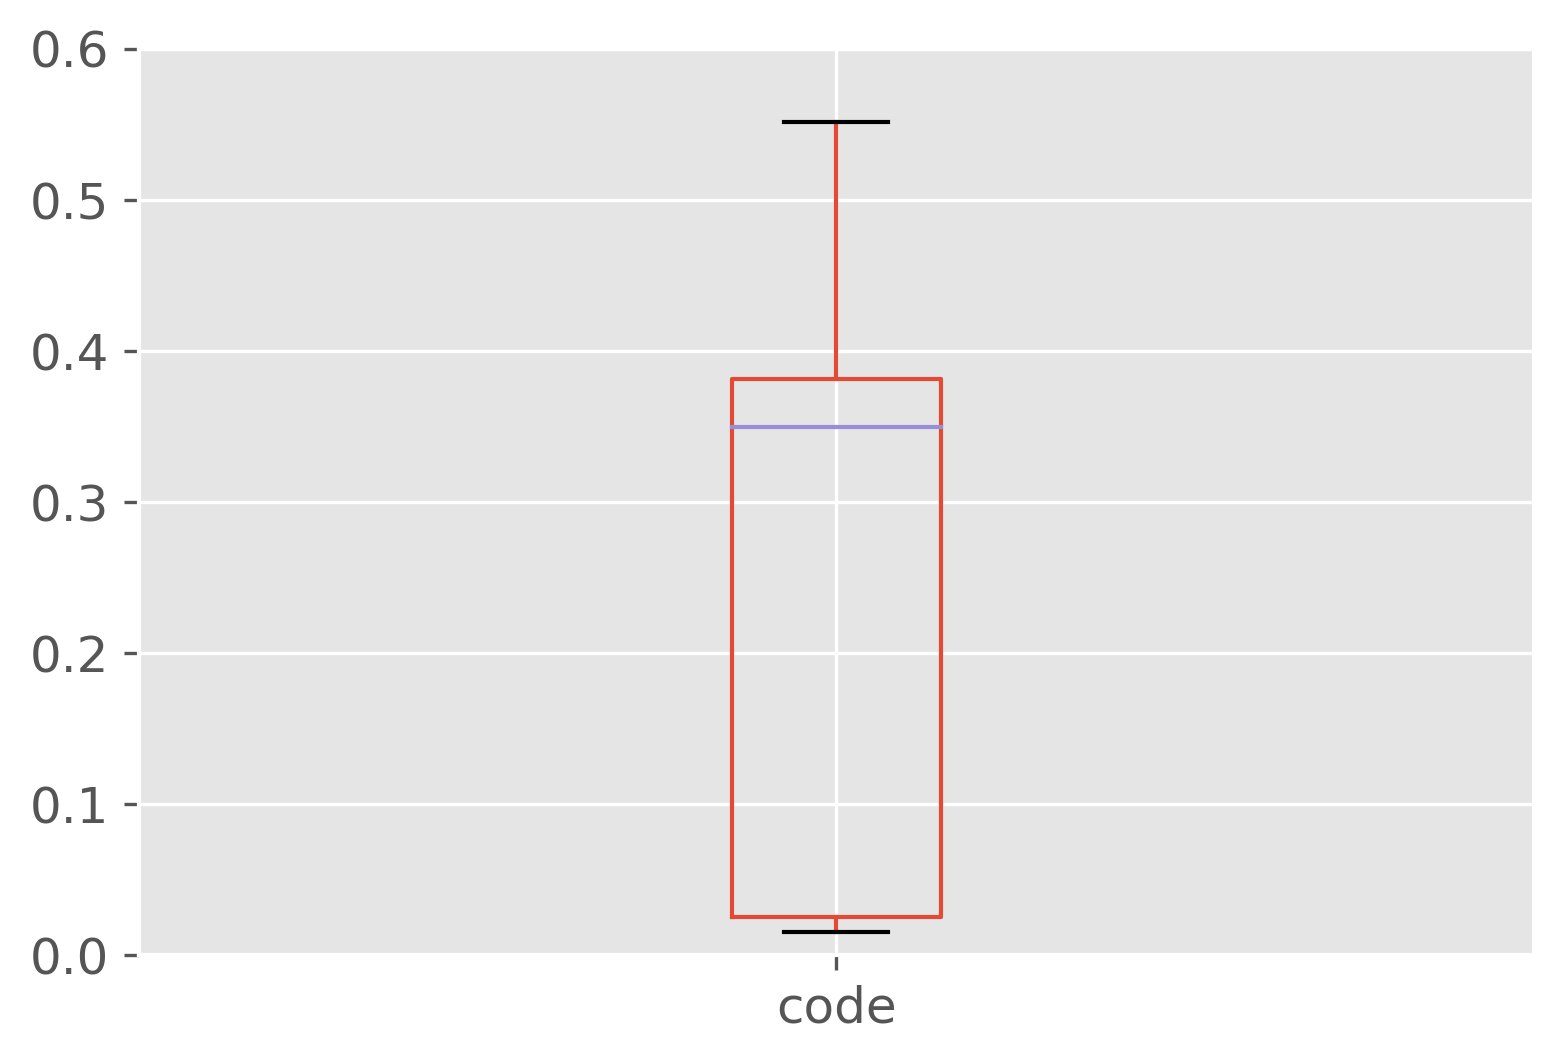

In [1664]:
code_test_all[code_test_all['y']==0][['code']].boxplot()
plt.ylim(0, 0.6)

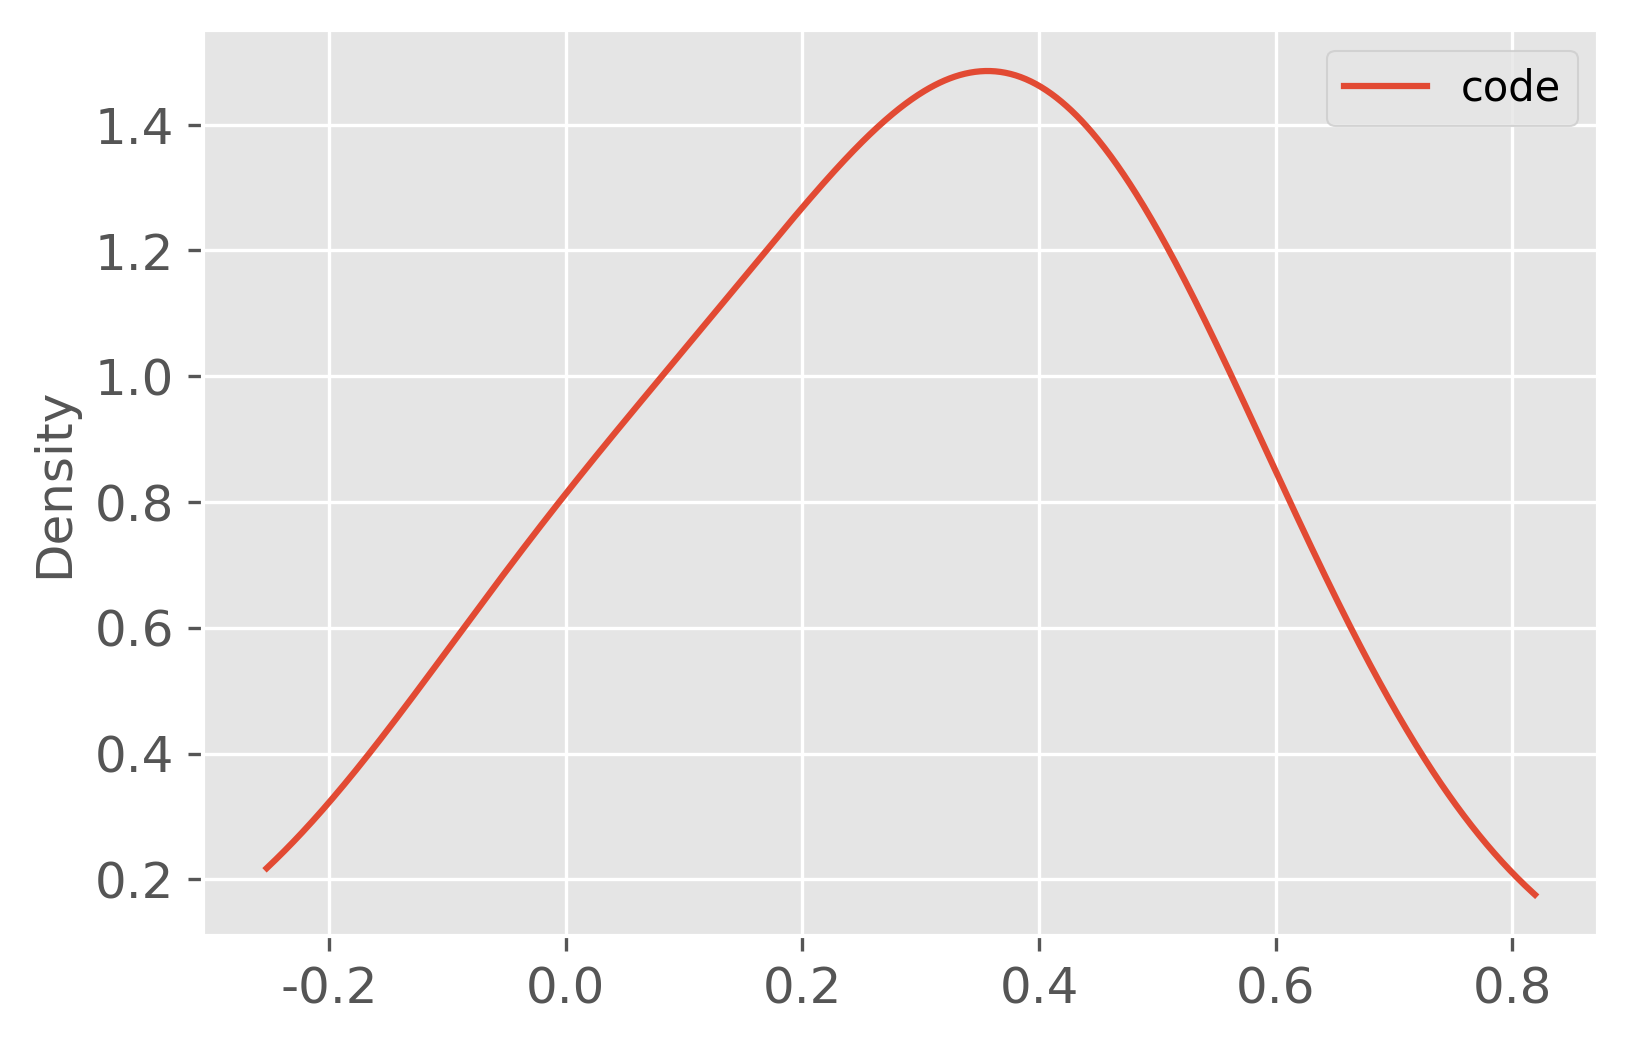

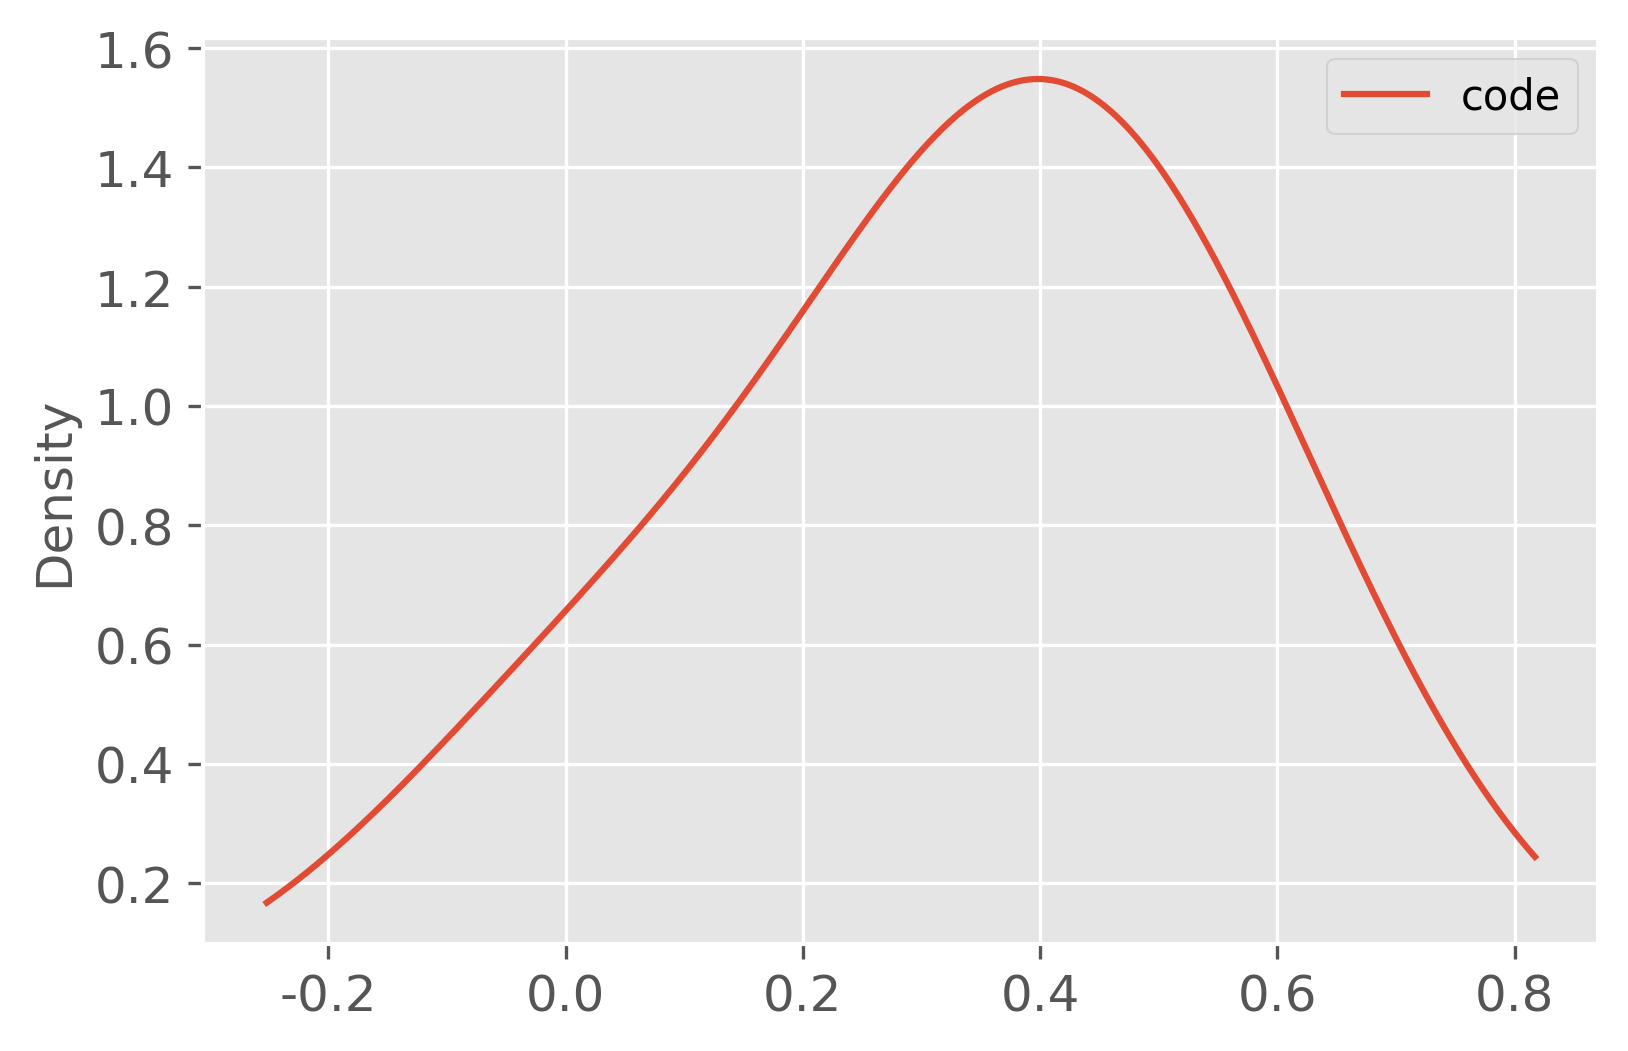

In [1678]:
code_test_all[code_test_all['y']==0][['code']].plot.kde(bw_method=1)
code_test_all[code_test_all['y']==1][['code']].plot.kde(bw_method=1)

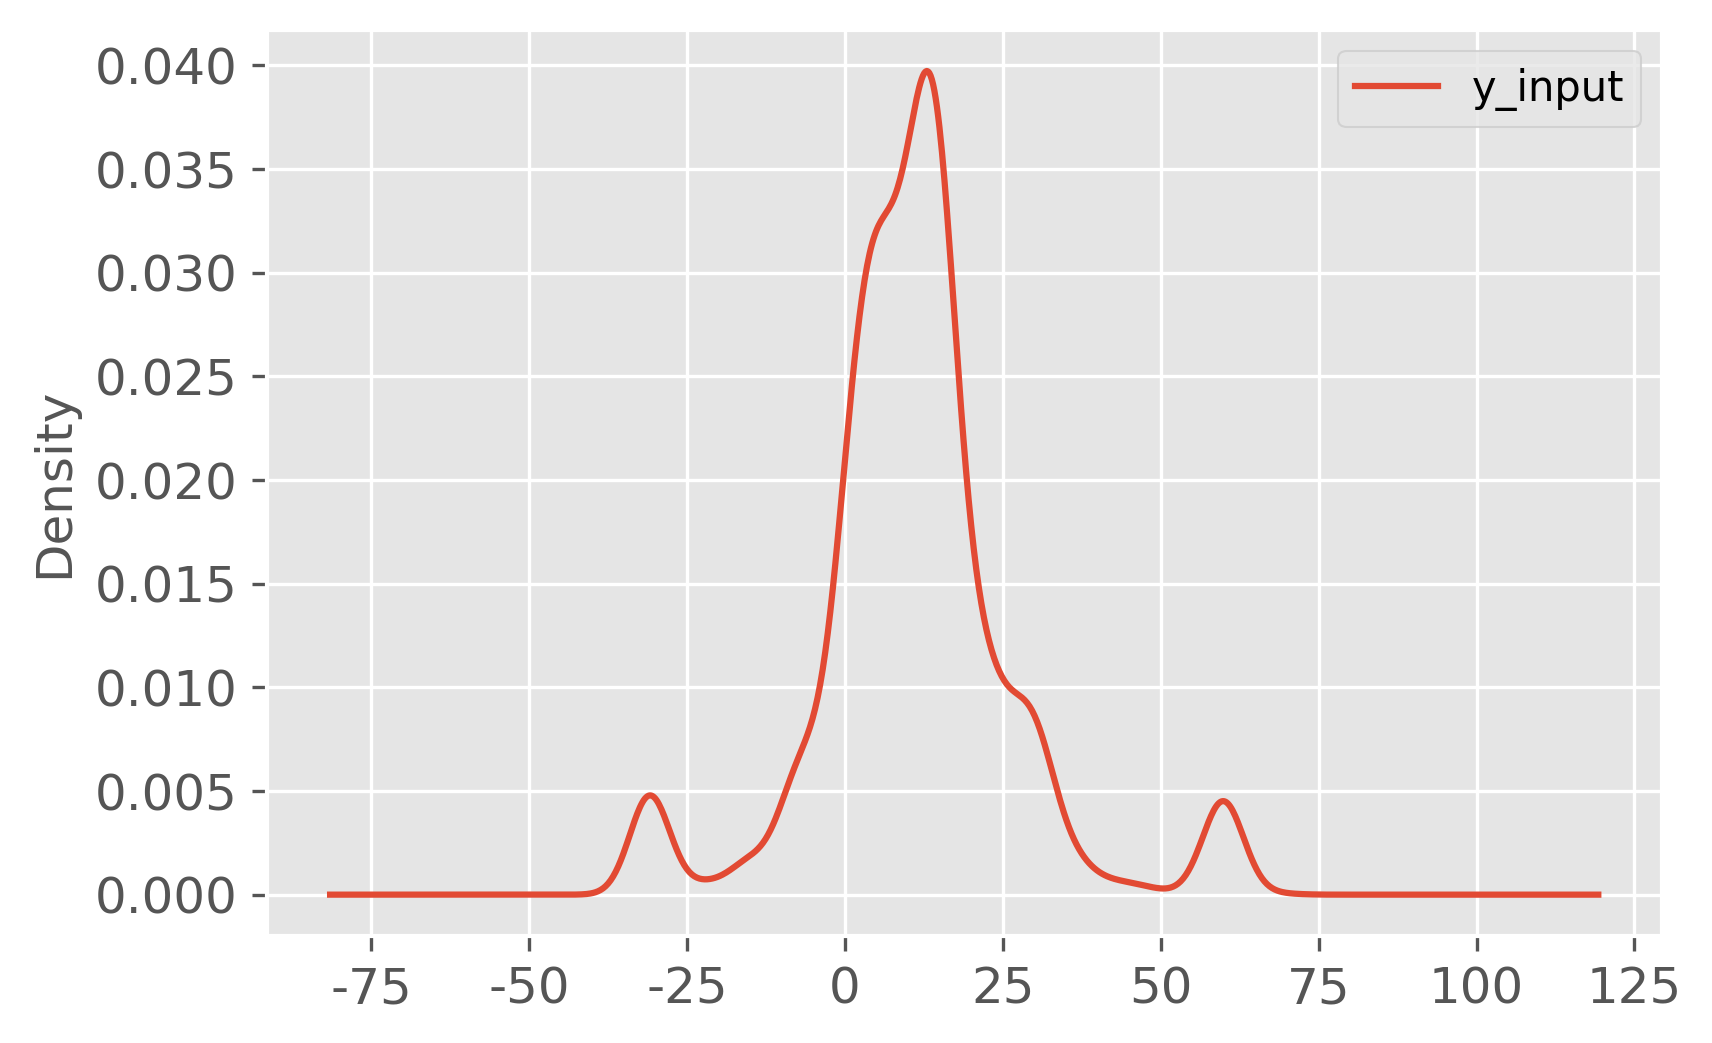

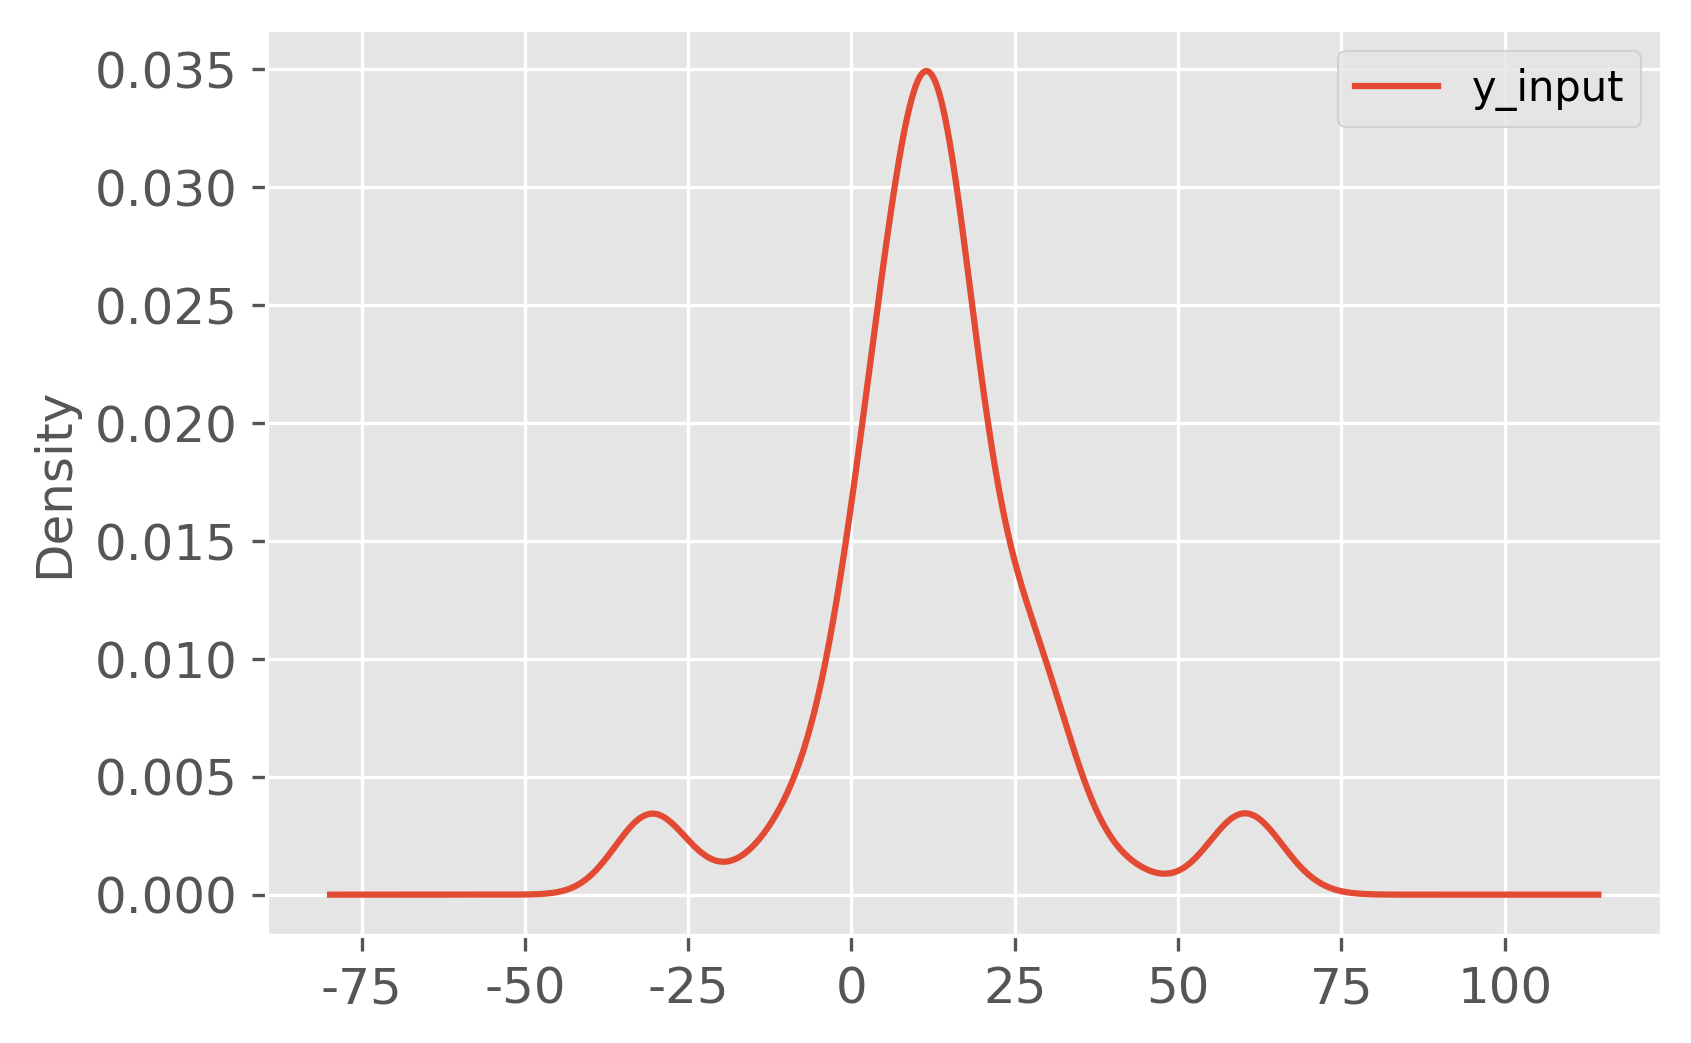

In [1670]:
test_data_all[test_data_all['y']==0][['y_input']].plot.kde()
test_data_all[test_data_all['y']==1][['y_input']].plot.kde()

(-40, 80)

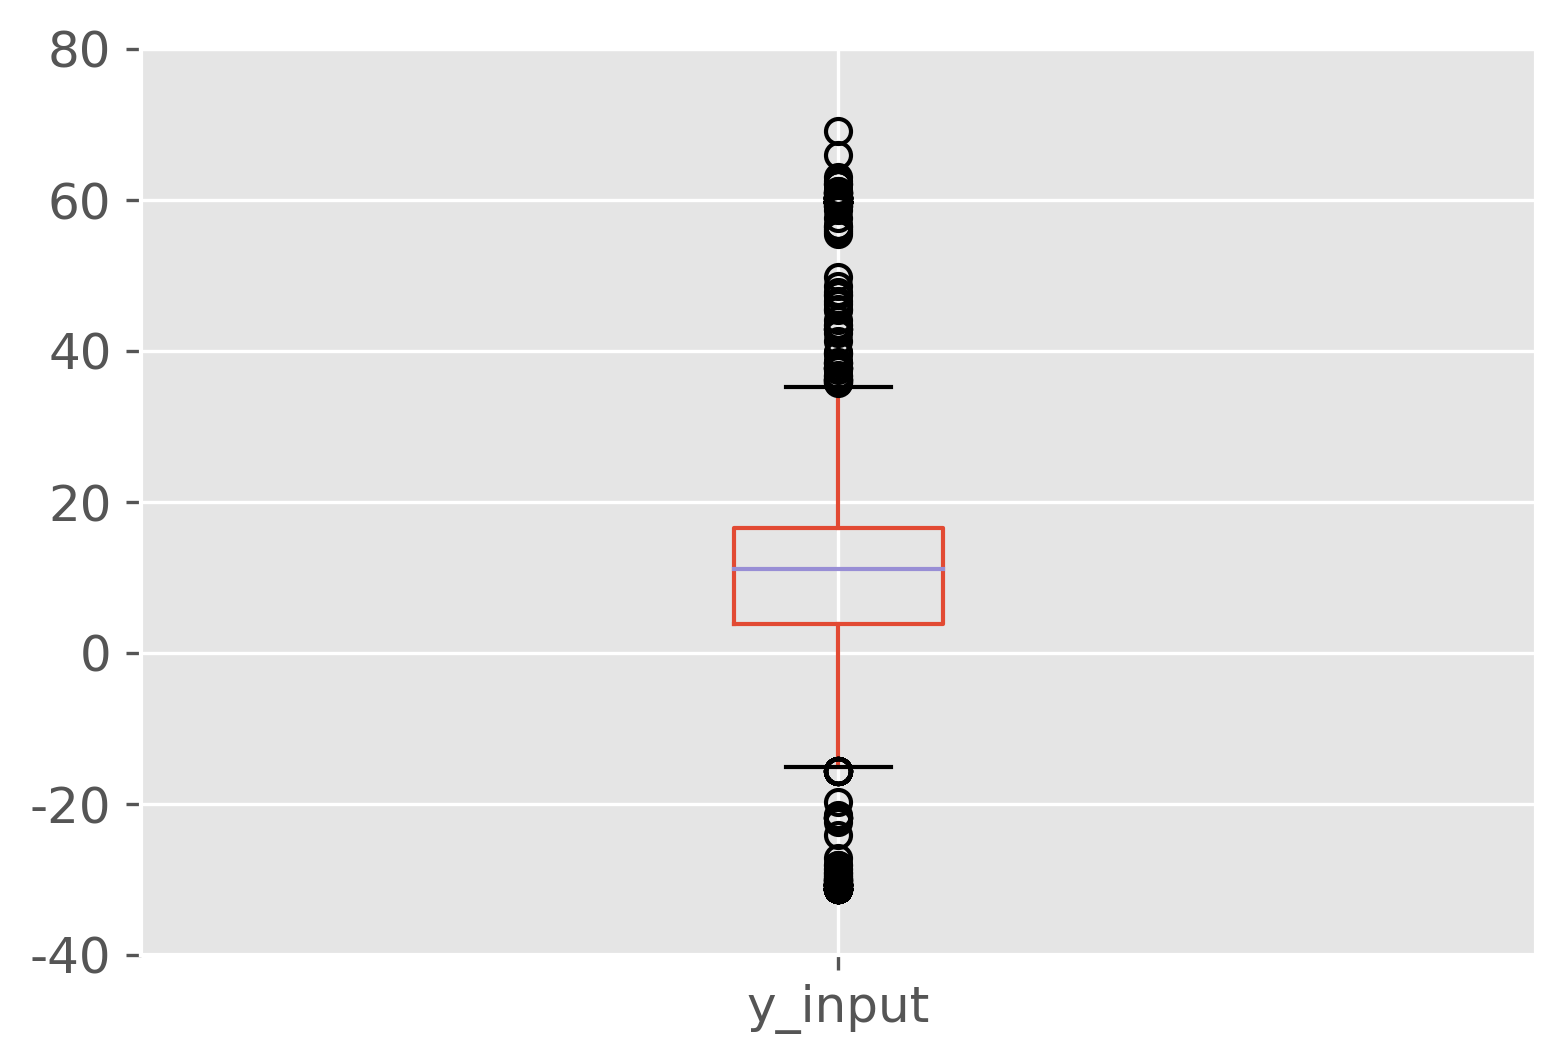

In [1665]:
test_data_all[test_data_all['y']==0][['y_input']].boxplot()
plt.ylim(-40, 80)

(0, 0.6)

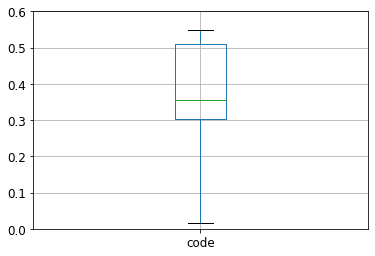

In [1464]:
code_test_all[code_test_all['y']==1][['code']].boxplot()
plt.ylim(0, 0.6)

(-40, 80)

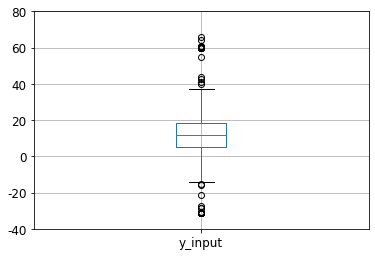

In [1462]:
test_data_all[test_data_all['y']==1][['y_input']].boxplot()
plt.ylim(-40, 80)

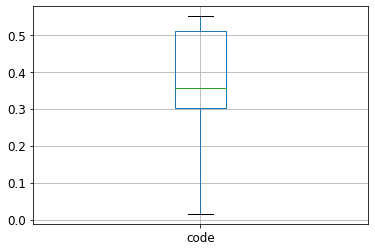

In [1434]:
code_test_all[code_test_all['y']==1][['code']].boxplot()

In [1336]:
# 검증용
for fold_num in range(0,5):
    merge_train_test_df = code_train_list[fold_num].rename(columns={'y': 'y1'})\
        .merge(create_y_merge_df('train', fold_num+1, 100).rename(columns={'y': 'y2'}), how='outer')
    print(fold_num, sum(merge_train_test_df['y1'] == merge_train_test_df['y2']),
          len(merge_train_test_df), len(code_train_list[fold_num]), len(create_y_merge_df('train', fold_num+1, 100)))
for fold_num in range(0,5):
    merge_test_test_df = code_test_list[fold_num].rename(columns={'y': 'y1'})\
        .merge(create_y_merge_df('test', fold_num+1, 100).rename(columns={'y': 'y2'}), how='outer')
    print(fold_num, sum(merge_test_test_df['y1'] == merge_test_test_df['y2']),
          len(merge_test_test_df), len(code_test_list[fold_num]), len(create_y_merge_df('test', fold_num+1, 100)))

0 3137 3137 3137 3137
1 3137 3137 3137 3137
2 3138 3138 3138 3138
3 3138 3138 3138 3138
4 3138 3138 3138 3138
0 785 785 785 785
1 785 785 785 785
2 784 784 784 784
3 784 784 784 784
4 784 784 784 784


In [1248]:
for method_num in range(len(model_dict)):
    print(fold_train_result[0][method_num][0])
    print(f'accuracy: {np.mean([x[method_num][1] for x in fold_train_result]):.6f}')
    print(f'precision: {np.mean([x[method_num][2][0][1] for x in fold_train_result]):.6f}')
    print(f'recall: {np.mean([x[method_num][2][1][1] for x in fold_train_result]):.6f}')
    print(f'f1: {np.mean([x[method_num][2][2][1] for x in fold_train_result]):.6f}')

Logistic Ridge
accuracy: 0.707290
precision: 0.169512
recall: 0.593688
f1: 0.263437
Logistic Lasso
accuracy: 0.706334
precision: 0.170255
recall: 0.600319
f1: 0.264998


In [1140]:
for method_num in range(len(model_dict)):
    print(fold_test_result[0][method_num][0])
    print(f'accuracy: {np.mean([x[method_num][1] for x in fold_test_result]):.6f}')
    print(f'precision: {np.mean([x[method_num][2][0][1] for x in fold_test_result]):.6f}')
    print(f'recall: {np.mean([x[method_num][2][1][1] for x in fold_test_result]):.6f}')
    print(f'f1: {np.mean([x[method_num][2][2][1] for x in fold_test_result]):.6f}')
    print(f'auc: {np.mean([x[method_num][3] for x in fold_test_result]):.6f}')

Logistic Ridge
accuracy: 0.666242
precision: 0.093750
recall: 0.444444
f1: 0.154839
auc: 0.576620
Logistic Lasso
accuracy: 0.664968
precision: 0.093385
recall: 0.444444
f1: 0.154341
auc: 0.576620
